<h1 align='center'> FORECASTING WITH DEEP LEARNING (PART II) </h1>

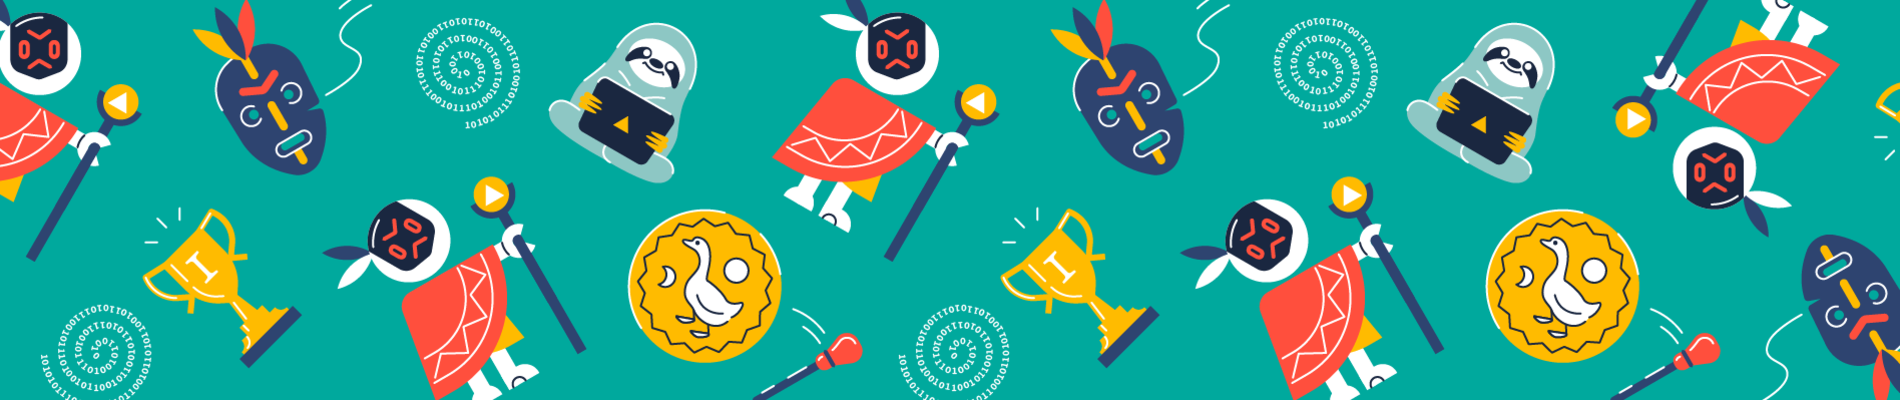

## Introduction

The first part of the forecasting with deep learning introduced various deep learning networks that were aimed to forecast one step ahead of time with a data set that included a time series of 5 years of 50 product sales from 10 different stores. This time we will try to forecast multiple steps ahead of time, or one year in the future, with a data set of a time series from 5 years of daily product sales from one store. Because the task is now much more difficult than in the previous part, the data set is simpler, and we will create some additional features that will help with the forecasting challenge.

In [1902]:
# Importing libraries

import numpy as np
import pandas as pd

from dataclasses import dataclass

from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, Callback
from keras.layers import Layer, Input

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
%matplotlib inline

# Visualization setup
plt.style.use('seaborn-whitegrid')

font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 16, 8
pd.set_option('max_columns', None)

# Seed & ignore warnings
from numpy.random import seed
seed(42)

import warnings
warnings.filterwarnings("ignore")

# Setup

shape of training set: (1462, 2), shape of valid set: (365, 2)


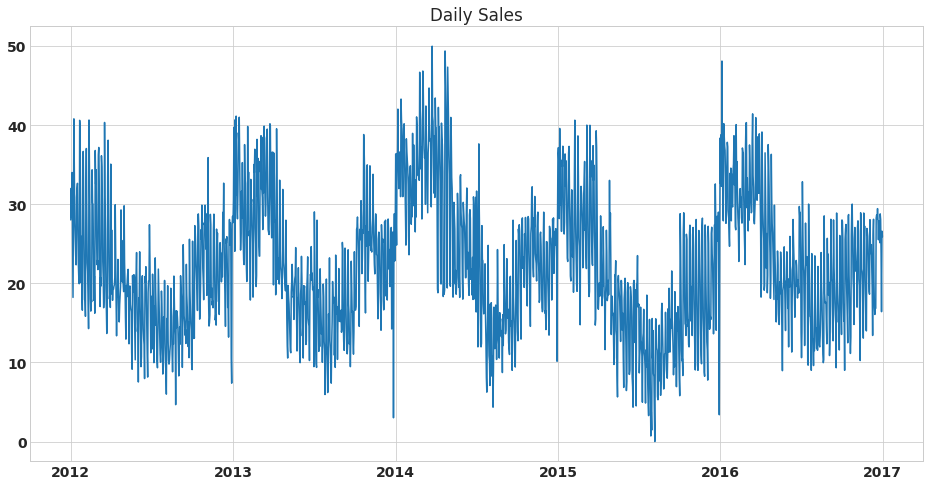

In [1981]:
# Global class to hold all parameters
@dataclass
class G:
    # Forecast of daily sales     
    TS = pd.read_csv('data/ts_daily.csv', sep = ';')
    TS['DATE'] = pd.to_datetime(TS['DATE'])
    TS.columns = ['date', 'sales']
    TS.index = TS['date']
    
    WINDOW_SIZE = 30 # One month window
    FORECAST_HORIZON = 365 # One year forecast
    FREQUENCY = 365 # Daily sales data
    BATCH_SIZE = 24 # Size of batches
    

def train_val_split(series, forecast_horizon):
    """Splits data into training and validation sets where the latter
    is the forecast horizon, the number of days of the multistep forecast.
    
    Args:
     series (pandas dataframe) - timeseries
     forecast_horizon (int) - number of timesteps to forecast in the future
     
    Output:
     time_train (pandas dataframe) - index of the time series for training
     series_train (pandas dataframe) - time series for training
     time_valid (pandas dataframe) - index of the time series for validation
     series_valid (pandas dataframe) - time series for validation
     
    """
    series_train = series.iloc[:-forecast_horizon, :]
    time_train = series_train['date']
    
    series_valid = series.iloc[-forecast_horizon:, :]
    time_valid = series_valid['date']
    
    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TS, G.FORECAST_HORIZON)
print("shape of training set: {}, shape of valid set: {}".format(series_train.shape, series_valid.shape)) 

def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data.

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """
    
    plt.figure(figsize=(16, 8))
    
    if type(y) is tuple:
      for y_curr in y:

        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      
      plt.plot(x[start:end], y[start:end], format)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if legend:
      plt.legend(legend)

    plt.title(title)
    plt.grid(True)

    plt.show()

# Plot the whole series 
plot_series(G.TS['date'], G.TS['sales'], title='Daily Sales')

In [1904]:
G.TS.describe()

sales
count  1827.000000
mean     22.259080
std       8.529927
min       0.000000
25%      16.070547
50%      20.928149
75%      27.998848
max      50.000000

In [1905]:
G.TS.isnull().sum()

date     0
sales    0
dtype: int64

Around 2000 total sold products over 5 years ranging from no products being sold at all to 50 products sold in one day, leading to an average of around 22 products sold each day. There are no null values so next we can explore the data through visualizations and time series analysis.

# Explorative Data Analysis

In [1906]:
# Plotting daily sales with Plotly

daily_sales_sc = go.Scatter(x=G.TS['date'], y=G.TS['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

## Time Series Analysis

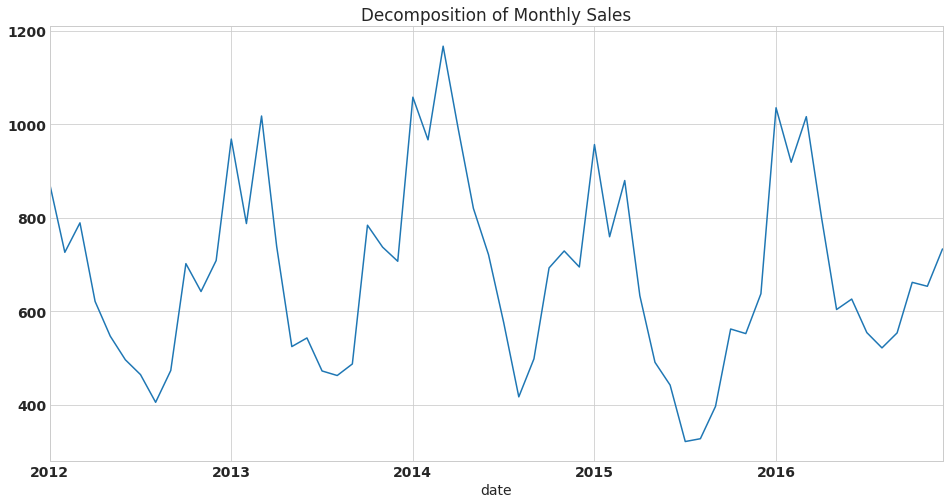

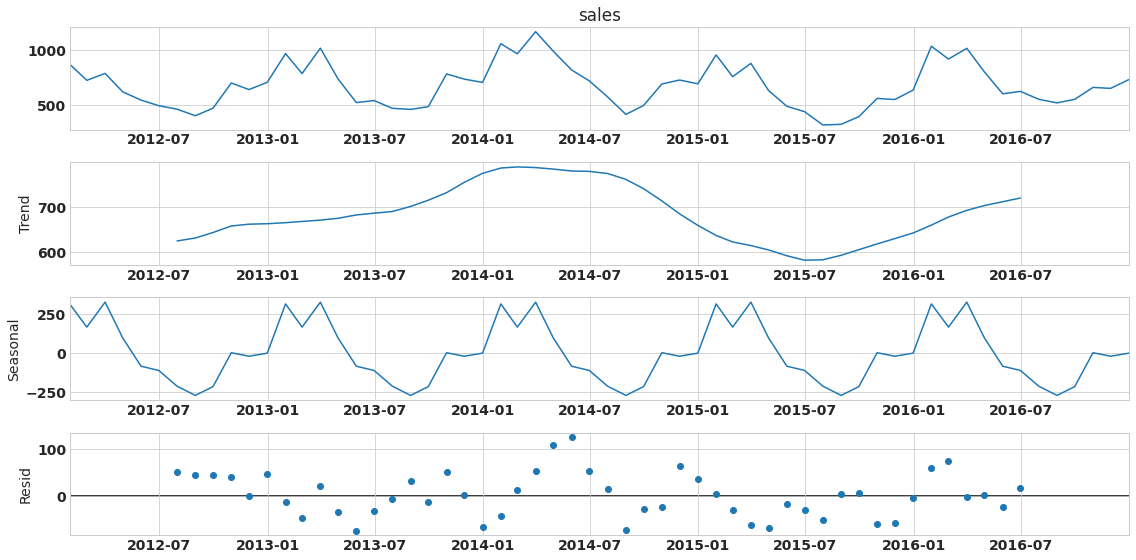

In [1907]:
# Sales decomposition

monthly_sales =  G.TS['sales'].resample('M').sum()
fig = monthly_sales.plot(kind='line', ax=plt.subplot(1,1,1))
plt.title('Decomposition of Monthly Sales')
fig = seasonal_decompose(monthly_sales, model='additive', period=12).plot()
plt.show()

We notice an upward moving trend from 2012 to 2014, and then a downward sloping trend until June 2015, from where the product sales again start climbing upwards. We also notice a clear seasonal fluctuation that moves upward each year from June onwards until around March when the sales peak, and from where the product sales start to slow down, the difference of the maximum and minimum peaks being around 250 product sales in a month. The residual is close to zero the first two years of the series, but after we see more random fluctuations that cannot be explained by the trend and seasonal components alone.

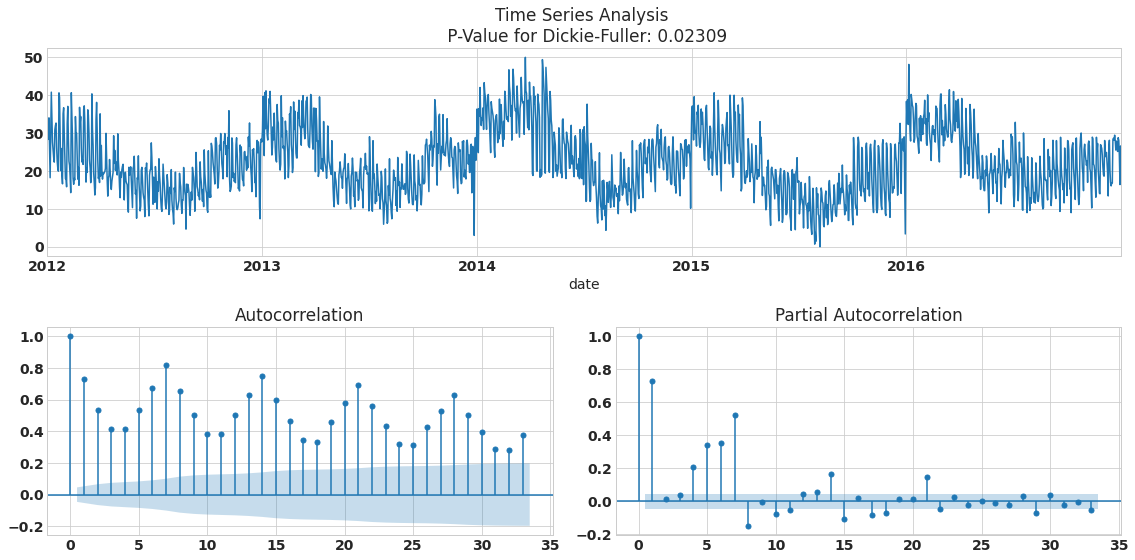

In [1984]:
# Time series analysis for product sales

def tsplot(series, lags=None):
    """
    Plots time series, ACF, PACF, and performs Augmented Dickey–Fuller test.
    
    Args:
     series (data set) - data for time series analysis
     lags (int) - optional lags for autocorrelation calculations
    """
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
           
    fig = plt.figure()
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    series.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(series)[1]
    ts_ax.set_title('Time Series Analysis \n P-Value for Dickie-Fuller: {0:.5f}'.format(p_value))
    plot_acf(series, lags=lags, ax=acf_ax)
    plot_pacf(series, lags=lags, ax=pacf_ax)
    plt.tight_layout()

tsplot(G.TS['sales'])

We can see that the series is stationary from the p-value of the Dickie-Fuller test so no further transformations are needed. The autocorrelation function indicates a decaying strong correlation that occurs at each first day of the week, and the last spike of over 0.6 correlation at day 28. The partial autocorrelation function has strong correlation on the first week, and after that, it decays and vanishes slowly towards zero.

# Feature Engineering

In [1978]:
# Function to calculate seasonal means

def calculate_seasonal_means(series, date_colname, y_colname, forecast_horizon, freq):
    """Calculates the seasonal means of a given time series

    Args:
        series (pandas dataframe) - dataset for creating seasonal means
        date_colname (str) - name of the date column 
        y_colname (str) - name of the target column 
        forecast_horizon (int) - number of periods to forecast into the future
        freq (int) - periodic frequency of the time series 

    Output:
        ts (list) - list of strings representing the header columns
    """
    keep_cols = list(series.columns)
    
    ts = series[[date_colname, y_colname]].copy()

    ts.index.name = 'index'
    ts.index = pd.to_datetime(ts[date_colname])
    ts.index.name = 'index'
    
    min_year = np.min(ts.index.year)
    max_year = np.max(ts.index.year) + int(forecast_horizon/freq) + 5

    all_dates = pd.DataFrame(pd.date_range(pd.to_datetime(str(min_year) + '-01-01'),
                  pd.to_datetime(str(max_year) + '-12-31')-timedelta(days=1),freq='d'), columns = ['ds'])

    ts['day_of_month'] = ts.index.day
    ts['day_of_week'] = ts.index.dayofweek
    ts['week'] = ts.index.week
    ts['quarter'] = ts.index.quarter
    ts['month'] = ts.index.month
    ts['weekly_monthly'] = ts['day_of_week'].astype(str) + ts['week'].astype(str) + ts['month'].astype(str)    
    
    ts = ts.fillna(0)
    
    day_week_mean = ts[['day_of_week', y_colname]].groupby(['day_of_week']).mean([y_colname]).reset_index()
    day_week_mean.columns = ['day_of_week', 'day_of_week_mean']
    ts = pd.merge(ts, day_week_mean, how = 'left', left_on = 'day_of_week', right_on = 'day_of_week')
    
    day_month_mean = ts[['day_of_month', y_colname]].groupby(['day_of_month']).mean([y_colname]).reset_index()
    day_month_mean.columns = ['day_of_month', 'day_of_month_mean']
    ts = pd.merge(ts, day_month_mean, how = 'left', left_on = 'day_of_month', right_on = 'day_of_month')
        
    quarter_mean = ts[['quarter', y_colname]].groupby(['quarter']).mean([y_colname]).reset_index()
    quarter_mean.columns = ['quarter', 'quarter_mean']
    ts = pd.merge(ts, quarter_mean, how = 'left', left_on = 'quarter', right_on = 'quarter')
        
    week_mean = ts[['week', y_colname]].groupby(['week']).mean([y_colname]).reset_index()
    week_mean.columns = ['week', 'week_mean']
    ts = pd.merge(ts, week_mean, how = 'left', left_on = 'week', right_on = 'week')
            
    month_mean = ts[['month', y_colname]].groupby(['month']).mean([y_colname]).reset_index()
    month_mean.columns = ['month', 'month_mean']
    ts = pd.merge(ts, month_mean, how = 'left', left_on = 'month', right_on = 'month')
    
    week_month_mean = ts[['weekly_monthly', y_colname]].groupby(['weekly_monthly']).mean([y_colname]).reset_index()
    week_month_mean.columns = ['weekly_monthly', 'weekly_monthly_mean']
    ts = pd.merge(ts, week_month_mean, how = 'left', left_on = 'weekly_monthly', right_on = 'weekly_monthly')
    
    ts.index = pd.to_datetime(series[date_colname])
    
    add_cols = list(set(keep_cols) - set(ts.columns))
    
    for col in add_cols:
        
        ts[col] = dataset[col]

    return ts

seasonal_means = calculate_seasonal_means(G.TS, 'date', 'sales', G.FORECAST_HORIZON, G.FREQUENCY)

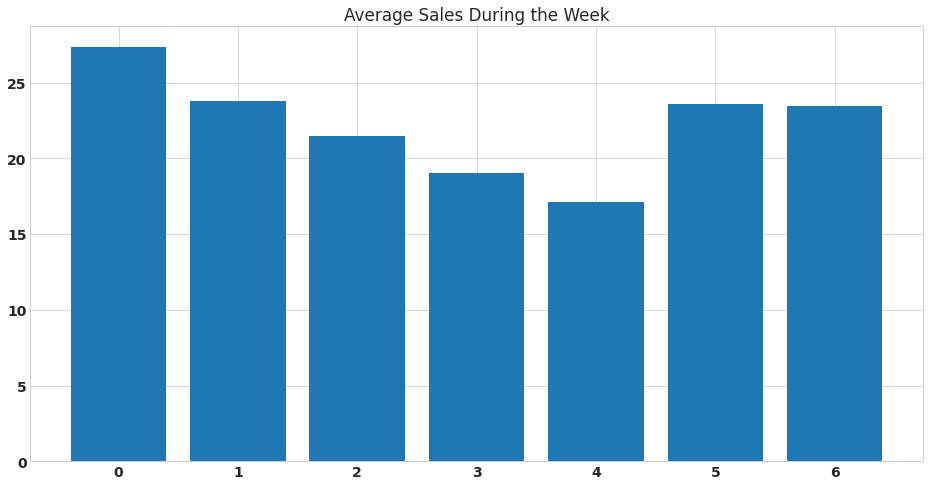

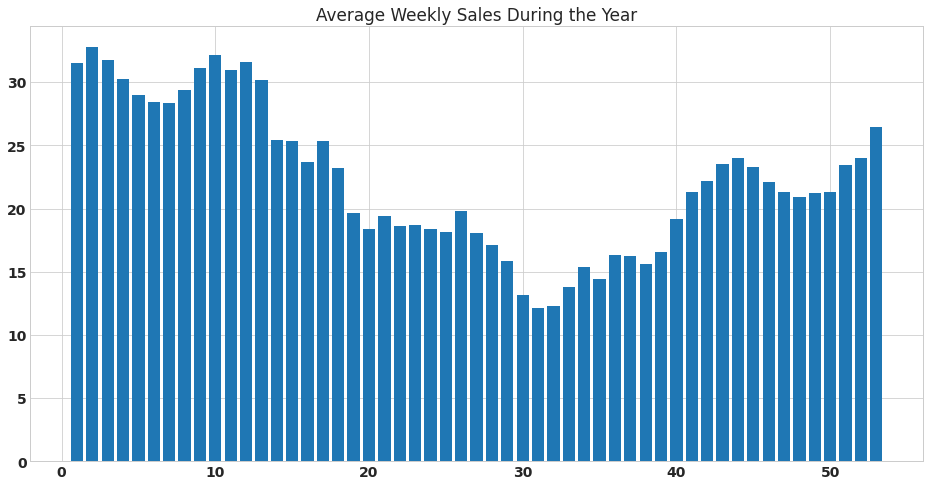

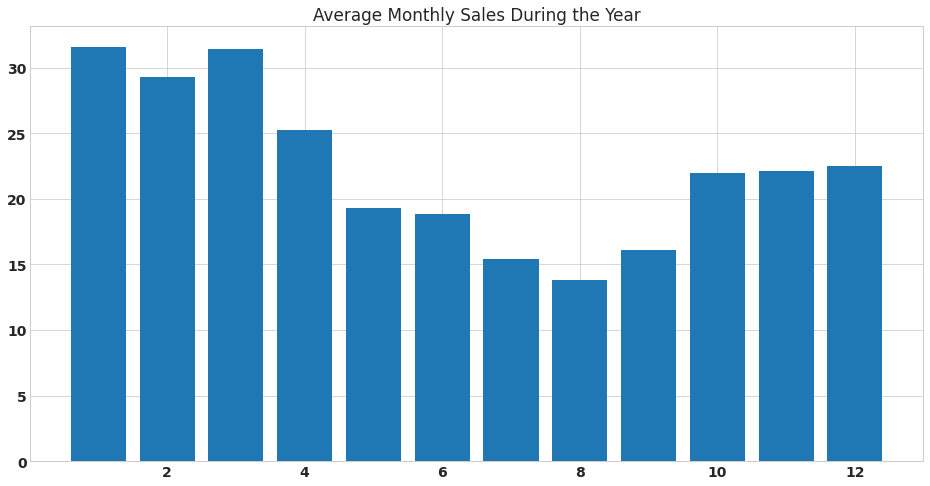

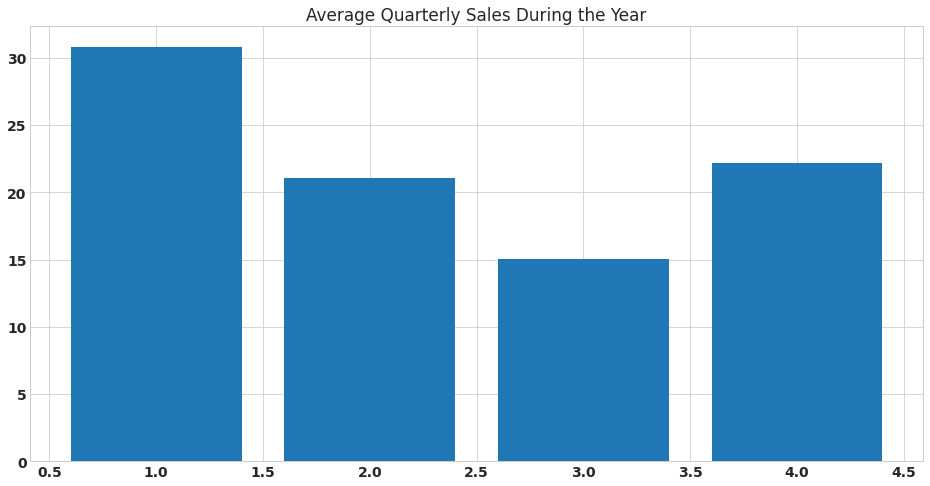

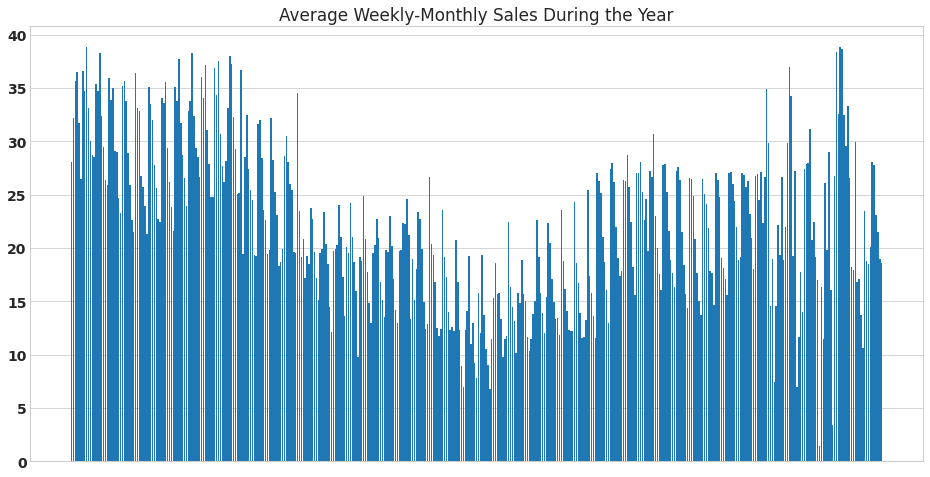

In [1910]:
# Plotting seasonal means

df = seasonal_means[['day_of_week','day_of_week_mean']].drop_duplicates()
plt.bar(df['day_of_week'], df['day_of_week_mean'])
plt.title('Average Sales During the Week')
plt.show()
    
df = seasonal_means[['week','week_mean']].drop_duplicates()
plt.bar(df['week'], df['week_mean'])
plt.title('Average Weekly Sales During the Year')
plt.show()
    
df = seasonal_means[['month','month_mean']].drop_duplicates()
plt.bar(df['month'], df['month_mean'])
plt.title('Average Monthly Sales During the Year')
plt.show()
    
df = seasonal_means[['quarter','quarter_mean']].drop_duplicates()
plt.bar(df['quarter'], df['quarter_mean'])
plt.title('Average Quarterly Sales During the Year')
plt.show()
    
df = seasonal_means[['weekly_monthly','weekly_monthly_mean']].drop_duplicates()
plt.bar(df['weekly_monthly'], df['weekly_monthly_mean'])
plt.title('Average Weekly-Monthly Sales During the Year')
plt.xticks([])
plt.show()

The created features have different shapes and sizes which will help the algorithm to learn the patterns from the data and hopefully guide for a better accuracy in the forecast.

In [1911]:
# Function to create sequences from the data set

def windowed_dataset(series, n_in=1, n_out=1):
    """Sequences take the form of a window, where the past timestep values
    are the features that are used to predict the future forecast sequence.
    
    Args:
     series (pandas dataframe) - dataset for creating sequences
     n_in (int) - number of timesteps behind
     n_out (int) - number of timesteps ahead
      
    Output:
     agg (pandas dataframe) - time series in sequences
     
    """
    n_vars = 1 if type(series) is list else series.shape[1]
    
    cols, names = list(), list()
        
    for i in range(n_in, 0, -1): # lag sequence (t-n, ... t-1)
        cols.append(series.shift(i))
        if i < 10:
            name_i = '0' + str(i)
        else:
            name_i = str(i)
              
        names += [(str(pd.DataFrame(series.iloc[:, j]).columns.values).replace("']",'').replace("['",'') +'_' + 'lag' + name_i) for j in range(n_vars)]
        
    for i in range(0, n_out): # lead sequence (t, t+1, ... t+n)
        cols.append(series.shift(-i))
        if i == 0:
            names += [(str(pd.DataFrame(series.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
        else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(series.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + 'lead' + name_i) for j in range(n_vars)]
        
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    
    return agg

In [1985]:
# Function to transform series into forecasting tasks

def dataprep_forecasting(series, date_colname, y_colname):
    """Prepares the series for forecasting, first by scaling with the mean and standard deviation,
    followed by calculating seasonal features, and finally by sequencing the dataset into sequences.
    
    Args:
     series (pandas dataframe) - timeseries
     date_colname (str) - name of the date column 
     y_colname (str) - name of the target column
      
    Output:
     ts_sequence (pandas datadrame) - sequenced time series for forecasting
     scaler (statistical method) - transforms the data
     
    """
    
    scaler = StandardScaler()
    ts = series.copy()

    y = ts[[y_colname]].copy()

    y = pd.DataFrame(scaler.fit_transform(y))
    y.columns = [y_colname]
    
    for y_colname in y.columns:
        ts[y_colname] = y[y_colname].values
    
    all_cols = [date_colname, y_colname]

    ts_seasonal_means = calculate_seasonal_means(series[all_cols], date_colname, y_colname, G.FORECAST_HORIZON, G.FREQUENCY)
        
    ts_seasonal_means.index = pd.to_datetime(series[date_colname])
    
    del ts_seasonal_means[date_colname]
    del ts_seasonal_means[y_colname]

    ts.index = pd.to_datetime(ts[date_colname])
    
    ts_sequence = windowed_dataset(ts[[y_colname]], n_in=G.WINDOW_SIZE, n_out=1)
    
    ts_sequence.index = pd.to_datetime(ts_sequence.index)
    ts_sequence.index.name = 'index'
    
    ts_sequence['week'] = ts_sequence.index.week
    ts_sequence['month'] = ts_sequence.index.month
    ts_sequence['quarter'] = ts_sequence.index.quarter
    ts_sequence['day_of_month'] = ts_sequence.index.day
    ts_sequence['day_of_week'] = ts_sequence.index.dayofweek
    ts_sequence['weekly_monthly'] = ts_sequence['day_of_week'].astype(str) + ts_sequence['week'].astype(str) + ts_sequence['month'].astype(str)
    
    for feat in ['week',
                 'month',
                'quarter',
                'day_of_month',
                'day_of_week',
                'weekly_monthly']:
        if feat in ts_seasonal_means.columns:
            seasonal_features = ts_seasonal_means[[feat, feat+'_mean']].drop_duplicates().reset_index(drop = True)
            ts_sequence = pd.merge(ts_sequence, seasonal_features[[feat, feat+'_mean']], how = 'left', left_on = feat, right_on = feat)

            del ts_sequence[feat]
        else:
            try:
                del ts_sequence[feat]
            except:
                pass
            pass
    
    for col in ts_sequence.columns:
        ts_sequence[col] = ts_sequence[col].values
        
    for col in ts_seasonal_means.columns:
        if col in ts_sequence.columns:
            ts_sequence[col] = StandardScaler().fit_transform(ts_sequence[[col]]).ravel()
    
    return ts_sequence, scaler

train_set, scaler_train = dataprep_forecasting(series_train, 'date', 'sales') 
val_set, scaler_valid = dataprep_forecasting(series_valid, 'date', 'sales')
full_set, scaler_forecast = dataprep_forecasting(G.TS, 'date', 'sales')

print("shape of training set: {}, shape of valid set: {}, shape of full set {}".format(train_set.shape, val_set.shape, full_set.shape)) 

shape of training set: (1432, 37), shape of valid set: (335, 37), shape of full set (1797, 37)


In [1986]:
# Function to transform series into machine learning tasks

def dataprep_3D(series, y_colname, date_colname, forecast_horizon):
    """Creates the dataset into 3D tensors where the first component consist of
    the samples or the time of the product sales, the second being the forecast horizon,
    and third the features.
    
    Args:
     series (pandas dataframe) - timeseries
     y_colname (str) - name of the target column
     date_colname (str) - name of the date column
     forecast_horizon (int) - number of timesteps to forecast in the future
      
    Output:
     x_seq (array of int) - sequenced training time series of the features for machine learning
     y_seq (array of int) - sequenced training time series of the target for machine learning
     val_seq (array of int) - sequenced validation time series of the features for machine learning
     feats (list) - list of names of the features
    """
    
    ts = series.copy()
    ts = ts[ts.columns.difference([date_colname])]

    x = ts[ts.columns.difference([date_colname])]
    y = ts[y_colname]
    feats = list(x.columns)
    
    x_list = []
    y_list = []
    i = 0
    
    for i in range(0, len(ts) - ((forecast_horizon*2)-1)):
        
        x_list.append([x.iloc[i: i+forecast_horizon].values])
        y_list.append([y.iloc[i+forecast_horizon: i+(forecast_horizon*2)][y_colname].values])
    
    x_seq = np.array(x_list).reshape(len(x) - ((forecast_horizon*2)-1), forecast_horizon, len(x.columns))
    y_seq = np.array(y_list).reshape(len(y) - ((forecast_horizon*2)-1), forecast_horizon, len(y_colname))


    val_seq = []
    i = 0
    
    for i in range(len(x) - forecast_horizon, len(x)- (forecast_horizon-1)):
        
        val_seq.append([x.iloc[i: i+forecast_horizon].values])
    
    val_seq = np.array(val_seq).reshape(1, forecast_horizon, len(x.columns))

    return x_seq, y_seq, val_seq, feats

X_train_sequence, y_train_sequence, X_test_sequence, feats = dataprep_3D(train_set, ['sales'], 'date', G.FORECAST_HORIZON)

X_train_full, y_train_full, X_forecast, feats = dataprep_3D(full_set, ['sales'], 'date', G.FORECAST_HORIZON)

print("shape of x training sequence: {}, shape of y training sequence: {}, shape of x testing sequence {}".format(X_train_sequence.shape, y_train_sequence.shape, X_test_sequence.shape)) 
print("shape of x full training sequence: {}, shape of y full training sequence: {}, shape of x forecasting sequence {}".format(X_train_full.shape, y_train_full.shape, X_forecast.shape)) 

shape of x training sequence: (703, 365, 37), shape of y training sequence: (703, 365, 1), shape of x testing sequence (1, 365, 37)
shape of x full training sequence: (1068, 365, 37), shape of y full training sequence: (1068, 365, 1), shape of x forecasting sequence (1, 365, 37)


In [1991]:
dict_explain_tensor = {}
x = 0 
for val in X_train_sequence.shape:
    if x == 0:
        dict_explain_tensor[val] = 'number of rows - samples of product sales from time'
    elif x == 1:
        dict_explain_tensor[val] = 'sequence length - number of steps to forecast ahead in time (forecast_horizon)'
    elif x == 2:
        dict_explain_tensor[val] = 'number of columns - features'
    print(val, dict_explain_tensor[val])
    x = x + 1

703 number of rows - samples of product sales from time
365 sequence length - number of steps to forecast ahead in time (forecast_horizon)
37 number of columns - features


In [1992]:
dict_explain_full_tensor = {}
x = 0 
for val in X_train_full.shape:
    if x == 0:
        dict_explain_full_tensor[val] = 'number of rows - samples of product sales from time'
    elif x == 1:
        dict_explain_full_tensor[val] = 'sequence length - number of steps to forecast ahead in time (forecast_horizon)'
    elif x == 2:
        dict_explain_full_tensor[val] = 'number of columns - features'
    print(val, dict_explain_full_tensor[val])
    x = x + 1

1068 number of rows - samples of product sales from time
365 sequence length - number of steps to forecast ahead in time (forecast_horizon)
37 number of columns - features


# Modeling

We will try different deep learning models such as the Long Short-Term Memory (LSTM) network, the Bidirectional LSTM, the Gated Recurrent Unit (GRU) network, and the Time2Vec (vector representation of time) to see how well they deal with the forecasting task. Finally, at the end we will do some combinations of the models in the form of ensemble modeling. 

The models will be trained and evaluated with the RMSE and MAE. After the first round of training, the second round will begin with the full training set that includes the validation set, and the goal will be to forecast the product sales for one year ahead of time.

## LSTM

In [1916]:
# Create the model

input_dim = int(X_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])

def LSTM_model():
    model = tf.keras.models.Sequential([
     #   tf.keras.layers.LSTM(units=256, kernel_initializer='glorot_uniform', activation='tanh', return_sequences=True),
        tf.keras.layers.LSTM(units=input_dim, kernel_initializer = 'glorot_uniform', activation = 'tanh',return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(units=output_dim, activation = 'linear')
    ], name = 'LSTM_model')
   
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True) 
    model.compile(loss='mse', optimizer=opt)
    
    return model

model_lstm = LSTM_model()

In [1917]:
# Train the model

monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=5)
history_lstm = model_lstm.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=50, 
                    batch_size = G.BATCH_SIZE, 
                    validation_data = (X_train_full[-G.FORECAST_HORIZON:,:, :], 
                                       y_train_full[-G.FORECAST_HORIZON:,:, :]), 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
30/30 [==============================] - 5s 107ms/step - loss: 1.1338 - val_loss: 1.0897
Epoch 2/50
30/30 [==============================] - 3s 94ms/step - loss: 1.0818 - val_loss: 1.0262
Epoch 3/50
30/30 [==============================] - 3s 92ms/step - loss: 1.0340 - val_loss: 0.9774
Epoch 4/50
30/30 [==============================] - 3s 93ms/step - loss: 0.9891 - val_loss: 0.9476
Epoch 5/50
30/30 [==============================] - 3s 93ms/step - loss: 0.9576 - val_loss: 0.9207
Epoch 6/50
30/30 [==============================] - 3s 93ms/step - loss: 0.9254 - val_loss: 0.9036
Epoch 7/50
30/30 [==============================] - 3s 96ms/step - loss: 0.9021 - val_loss: 0.8967
Epoch 8/50
30/30 [==============================] - 3s 116ms/step - loss: 0.8673 - val_loss: 0.8709
Epoch 9/50
30/30 [==============================] - 3s 98ms/step - loss: 0.8235 - val_loss: 0.8688
Epoch 10/50
30/30 [==============================] - 3s 92ms/step - loss: 0.7923 - val_loss: 0.8980
Epoch 1

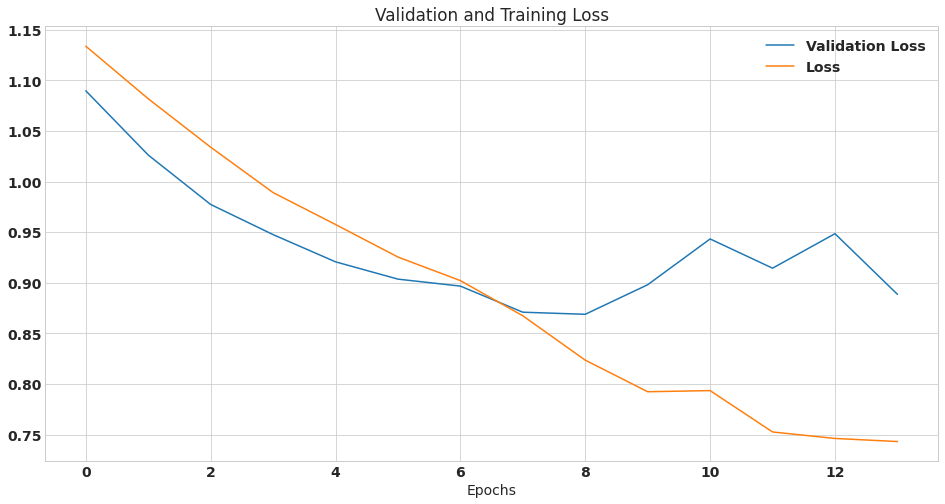

Best epoch : 8


In [1918]:
# Plot training loss

plot_series(
    x=range(len(history_lstm.history['loss'])), 
    y=(history_lstm.history['val_loss'], history_lstm.history['loss']), 
    title='Validation and Training Loss', 
    xlabel='Epochs',
    legend=['Validation Loss', 'Loss']
    )

hist = pd.DataFrame(history_lstm.history)
hist['epoch'] = history_lstm.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('Best epoch :', best_epoch)

In [1919]:
model_lstm.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_232 (LSTM)             (None, 37)                11100     
                                                                 
 dropout_68 (Dropout)        (None, 37)                0         
                                                                 
 dense_231 (Dense)           (None, 365)               13870     
                                                                 
Total params: 24,970
Trainable params: 24,970
Non-trainable params: 0
_________________________________________________________________


In [1920]:
# Make forecast

pred_lstm = pd.DataFrame(model_lstm.predict(X_test_sequence)).T

1/1 [==============================] - 0s 398ms/step


In [1921]:
# Evaluate results

def compute_metrics(true_series, forecast):
    """
    Evaluate forecast with MSE and MAE.
    
    Args:
     true_series (array of int) - dataset for validating
     forecast (array of int) - forecast from the model
     
    Output:
     mse (metric) - mean squared error
     mae (metric) - mean absolute error
    """
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    
    return mse, mae

y_true = pd.DataFrame(G.TS['sales'][-G.FORECAST_HORIZON:].values.reshape(-1,1))

mse, mae = compute_metrics(y_true, scaler_train.inverse_transform(pred_lstm[:]))

print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 6.042, mae: 4.954


In [1922]:
# Training model to forecast 1 year ahead

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=2)

model_lstm = create_LSTM()

history_lstm = model_lstm.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = G.BATCH_SIZE, 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

forecast_lstm = model_lstm.predict(X_forecast).astype(float)
forecast_lstm_df = pd.DataFrame(scaler_forecast.inverse_transform(forecast_lstm).T)
forecast_lstm_df.columns = ['Y_PRED']

Epoch 1/8
45/45 [==============================] - 6s 86ms/step - loss: 1.1245
Epoch 2/8
45/45 [==============================] - 4s 89ms/step - loss: 1.0325
Epoch 3/8
45/45 [==============================] - 4s 98ms/step - loss: 0.9698
Epoch 4/8
45/45 [==============================] - 4s 79ms/step - loss: 0.9199
Epoch 5/8
45/45 [==============================] - 4s 87ms/step - loss: 0.8765
Epoch 6/8
45/45 [==============================] - 5s 103ms/step - loss: 0.9013
Epoch 7/8
45/45 [==============================] - 6s 138ms/step - loss: 0.7968
Epoch 8/8
1/1 [==============================] - 0s 376ms/step


In [1979]:
# Create index for forecast

def create_forecast_index(series, date_colname, forecast_horizon):
    """
    Creates an expanded index for time series.
    
    Args:
     series (pandas dataframe) - timeseries
     date_colname (str) - name of the date column
     forecast_horizon (int) - number of timesteps to forecast in the future
     
    Output:
     forecast_dates (pandas dataframe) - index for forecasting
    """
    
    
    forecast_dates = pd.DataFrame([ max(series.index) + relativedelta(days=1) ])
    
    if forecast_horizon >= 2:
        for i in range(2, forecast_horizon+1):
            forecast_dates = forecast_dates.append([max(series.index) + relativedelta(days=i)])    
        forecast_dates.columns = [date_colname] 
        forecast_dates.index = forecast_dates[date_colname]             
    
    else:
        forecast_dates.columns = [date_colname] 
        forecast_dates.index = forecast_dates[date_colname]     
   
            
    return forecast_dates

forecast_dates = create_forecast_index(G.TS, 'date', G.FORECAST_HORIZON)
forecast_lstm_df.index = forecast_dates.index

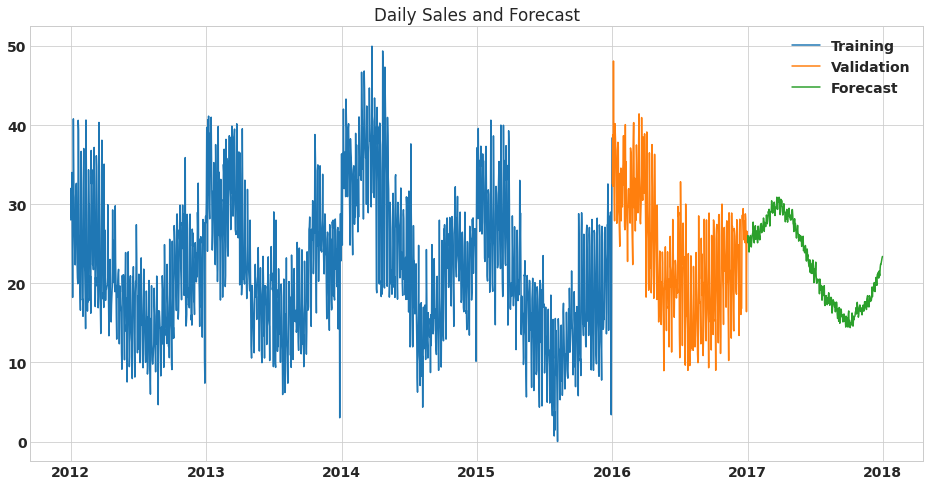

In [1924]:
# Plot whole series + forecast

fig, ax = plt.subplots(figsize = (16,8))
ax.plot(G.TS.index[:-G.FORECAST_HORIZON],  G.TS['sales'][:-G.FORECAST_HORIZON])
ax.plot(G.TS.index[-G.FORECAST_HORIZON:], G.TS['sales'][-G.FORECAST_HORIZON:])
ax.plot(forecast_lstm_df.index, forecast_lstm_df)
plt.title('Daily Sales and Forecast')
plt.grid('True')
plt.legend(['Training', 'Validation', 'Forecast'])
plt.show()

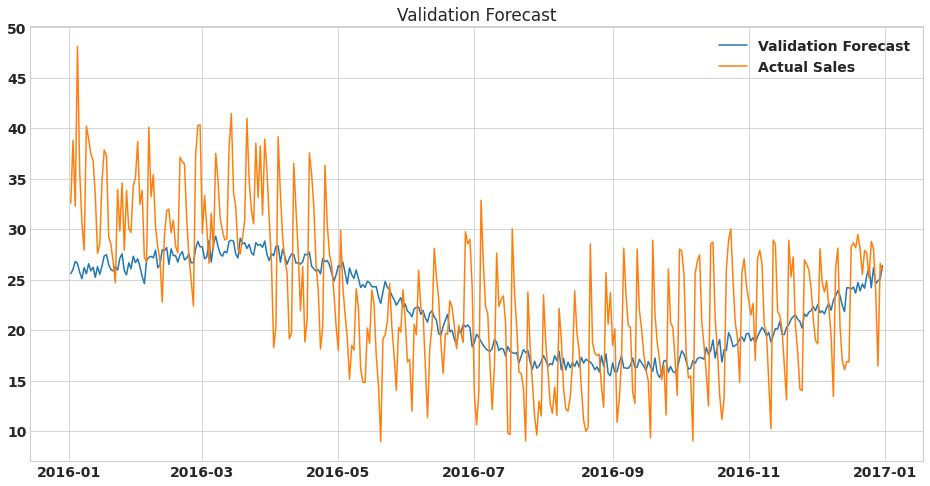

In [1925]:
# Plot validation forecast

plot_series(G.TS.index[-G.FORECAST_HORIZON:], (scaler_train.inverse_transform(pred_lstm),G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['Validation Forecast', 'Actual Sales'])

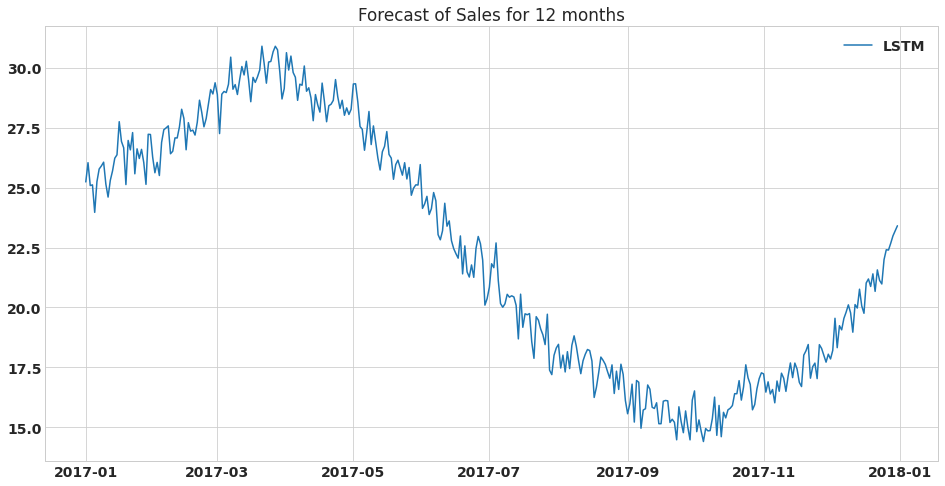

In [1926]:
# Forecast for 1 year ahead

plot_series(forecast_lstm_df.index, forecast_lstm_df, title='Forecast of Sales for 12 months', legend=['LSTM'])

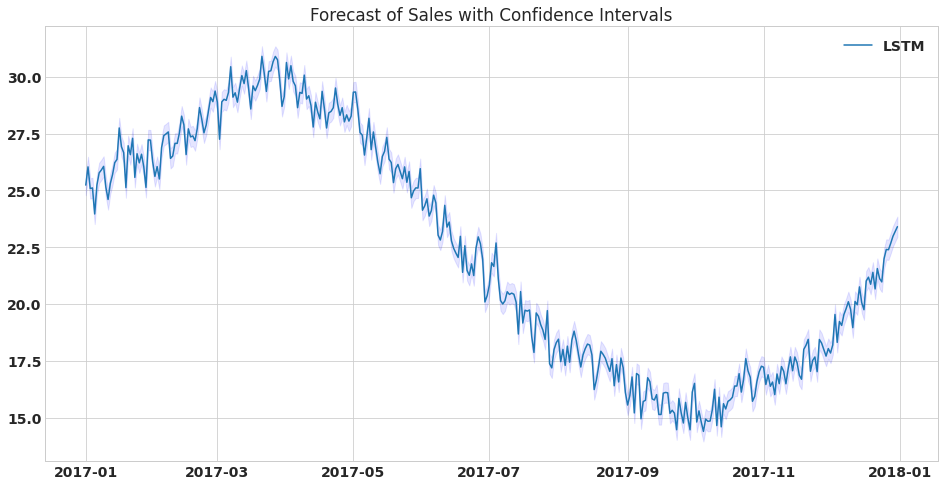

In [2114]:
# Forecast for 1 year ahead with confidence intervals

ci = 1.960*forecast_lstm_df.std(axis=0)/forecast_lstm_df.mean(axis=0)
ci_minus = np.array([x - ci for x in forecast_lstm_df['Y_PRED']]).ravel()
ci_plus = np.array([x + ci for x in forecast_lstm_df.values]).ravel()

plt.plot(forecast_lstm_df.index, forecast_lstm_df.values)
plt.fill_between(forecast_lstm_df.index, ci_plus, ci_minus, color='b', alpha=.1)
plt.legend(['LSTM'])
plt.title('Forecast of Sales with Confidence Intervals')
plt.show()

## BiLSTM

In [1928]:
# Creating the model
input_dim = int(X_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])

def BILSTM_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(LSTM(units=input_dim,
                                          return_sequences=False,
                                          kernel_initializer = 'glorot_uniform',
                                          activation = 'tanh')),
       # tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=output_dim, activation = 'linear')
    ], name='Bidirectional-LSTM_model')
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4) 
    model.compile(loss='mse', optimizer=opt)
    
    return model

model_bilstm = BILSTM_model()

In [1929]:
# Training the model

monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=7)
history_bilstm = model_bilstm.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs = 150, 
                    batch_size = G.BATCH_SIZE, 
                    validation_data = (X_train_full[-G.FORECAST_HORIZON:,:, :], 
                                       y_train_full[-G.FORECAST_HORIZON:,:, :]), 
                    shuffle = False,
                    verbose = 1,
                    callbacks = [early_stop])

Epoch 1/150
30/30 [==============================] - 11s 258ms/step - loss: 1.1522 - val_loss: 1.1470
Epoch 2/150
30/30 [==============================] - 5s 156ms/step - loss: 1.1321 - val_loss: 1.1303
Epoch 3/150
30/30 [==============================] - 6s 210ms/step - loss: 1.1147 - val_loss: 1.1141
Epoch 4/150
30/30 [==============================] - 6s 214ms/step - loss: 1.0977 - val_loss: 1.0978
Epoch 5/150
30/30 [==============================] - 5s 177ms/step - loss: 1.0804 - val_loss: 1.0811
Epoch 6/150
30/30 [==============================] - 8s 254ms/step - loss: 1.0624 - val_loss: 1.0641
Epoch 7/150
30/30 [==============================] - 5s 160ms/step - loss: 1.0437 - val_loss: 1.0471
Epoch 8/150
30/30 [==============================] - 5s 163ms/step - loss: 1.0247 - val_loss: 1.0307
Epoch 9/150
30/30 [==============================] - 7s 242ms/step - loss: 1.0060 - val_loss: 1.0154
Epoch 10/150
30/30 [==============================] - 5s 163ms/step - loss: 0.9883 - val_l

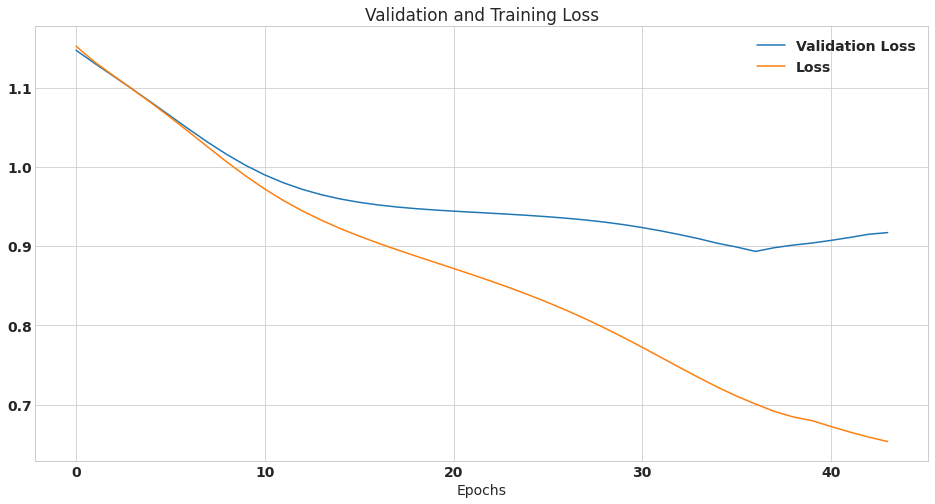

Best epoch : 36


In [1930]:
# Plot training loss

plot_series(
    x=range(len(history_bilstm.history['loss'])), 
    y=(history_bilstm.history['val_loss'], history_bilstm.history['loss']), 
    title='Validation and Training Loss', 
    xlabel='Epochs',
    legend=['Validation Loss', 'Loss']
    )

hist = pd.DataFrame(history_bilstm.history)
hist['epoch'] = history_bilstm.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('Best epoch :', best_epoch)

In [1931]:
model_bilstm.summary()

Model: "Bidirectional-LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_180 (Bidirect  (None, 74)               22200     
 ional)                                                          
                                                                 
 dense_233 (Dense)           (None, 365)               27375     
                                                                 
Total params: 49,575
Trainable params: 49,575
Non-trainable params: 0
_________________________________________________________________


In [1932]:
# Make forecast

pred_bilstm = pd.DataFrame(model_bilstm.predict(X_test_sequence)).T

1/1 [==============================] - 1s 694ms/step


In [1933]:
# Evaluate results

mse, mae = compute_metrics(y_true, scaler_train.inverse_transform(pred_bilstm))

print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 5.924, mae: 4.746


In [1934]:
# Training model to forecast 1 year ahead

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=2)

model_bilstm = BILSTM_model()

history_bilstm = model_bilstm.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = G.BATCH_SIZE, 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

forecast_bilstm = model_bilstm.predict(X_forecast).astype(float)
forecast_bilstm_df = pd.DataFrame(scaler_forecast.inverse_transform(forecast_bilstm).T)
forecast_bilstm_df.columns = ['Y_PRED']

Epoch 1/36
45/45 [==============================] - 10s 152ms/step - loss: 1.1689
Epoch 2/36
45/45 [==============================] - 6s 131ms/step - loss: 1.1385
Epoch 3/36
45/45 [==============================] - 9s 194ms/step - loss: 1.1108
Epoch 4/36
45/45 [==============================] - 6s 136ms/step - loss: 1.0830
Epoch 5/36
45/45 [==============================] - 9s 202ms/step - loss: 1.0552
Epoch 6/36
45/45 [==============================] - 6s 130ms/step - loss: 1.0287
Epoch 7/36
45/45 [==============================] - 8s 179ms/step - loss: 1.0048
Epoch 8/36
45/45 [==============================] - 6s 139ms/step - loss: 0.9840
Epoch 9/36
45/45 [==============================] - 8s 184ms/step - loss: 0.9663
Epoch 10/36
45/45 [==============================] - 9s 188ms/step - loss: 0.9511
Epoch 11/36
45/45 [==============================] - 8s 177ms/step - loss: 0.9379
Epoch 12/36
45/45 [==============================] - 7s 150ms/step - loss: 0.9260
Epoch 13/36
45/45 [=====

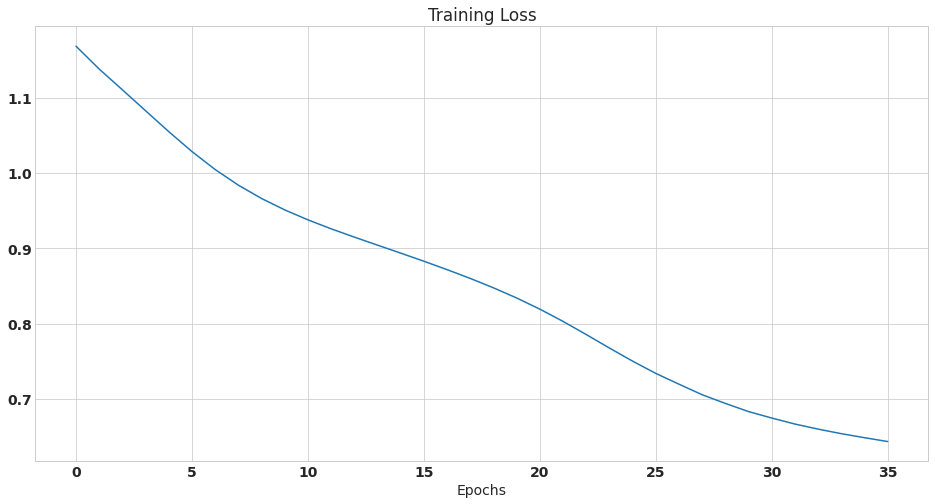

In [1935]:
# Plot training loss

plot_series(
    x=range(len(history_bilstm.history['loss'])), 
    y=history_bilstm.history['loss'], 
    title='Training Loss', 
    xlabel='Epochs'
    )

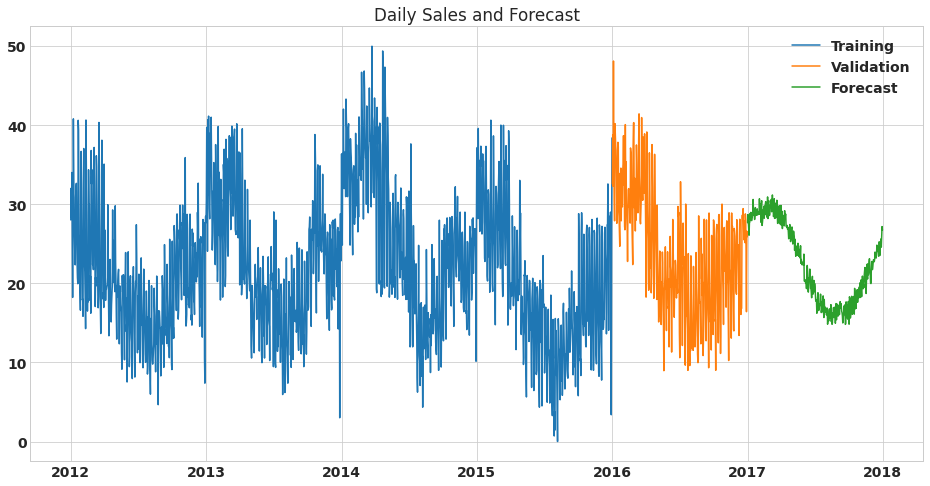

In [1936]:
# Plot whole series + forecast

forecast_bilstm_df.index = forecast_dates.index
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(G.TS.index[:-G.FORECAST_HORIZON],  G.TS['sales'][:-G.FORECAST_HORIZON])
ax.plot(G.TS.index[-G.FORECAST_HORIZON:], G.TS['sales'][-G.FORECAST_HORIZON:])
ax.plot(forecast_bilstm_df.index, forecast_bilstm_df)
plt.title('Daily Sales and Forecast')
plt.grid('True')
plt.legend(['Training', 'Validation', 'Forecast'])
plt.show()

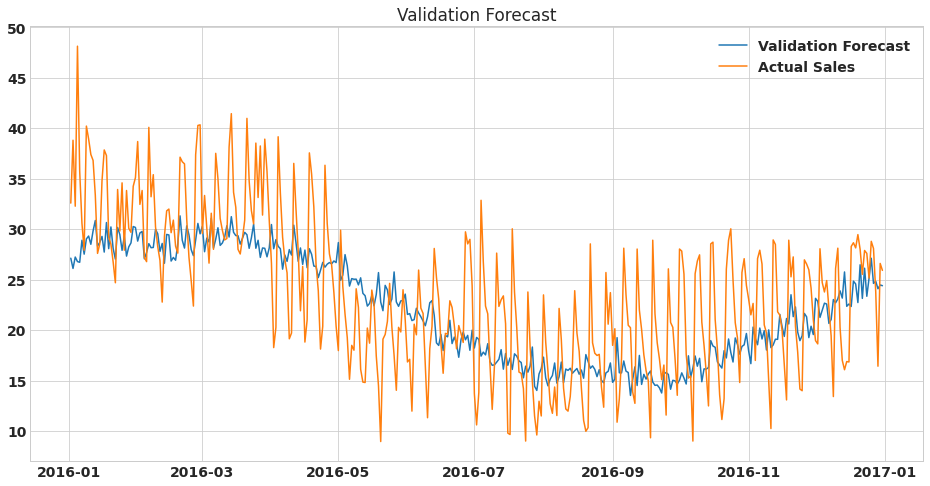

In [1937]:
# Plot validation forecast

plot_series(G.TS.index[-G.FORECAST_HORIZON:], (scaler_train.inverse_transform(pred_bilstm),G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['Validation Forecast', 'Actual Sales'])

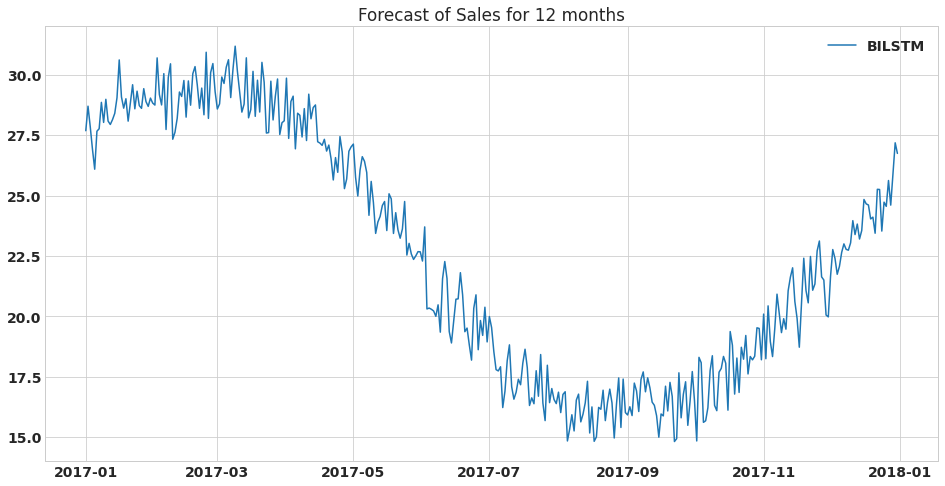

In [1938]:
# Forecast for 1 year ahead

plot_series(forecast_bilstm_df.index, forecast_bilstm_df, title='Forecast of Sales for 12 months', legend=['BILSTM'])

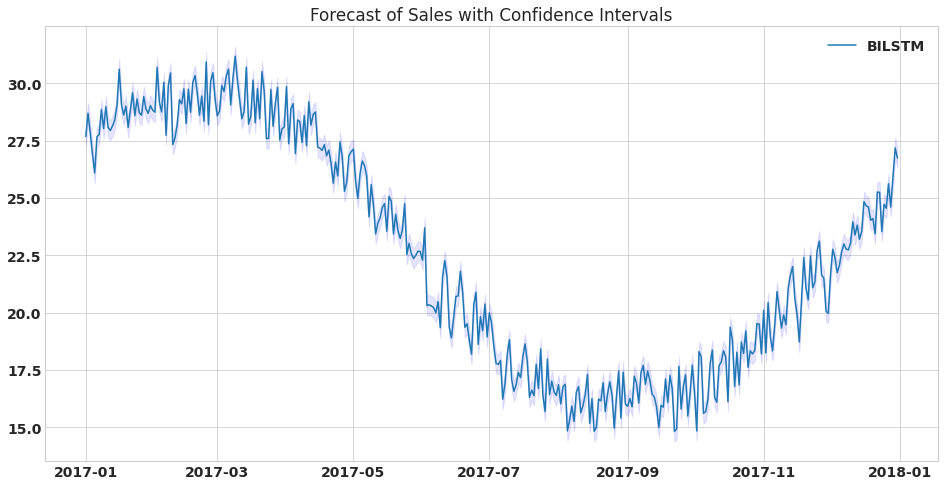

In [2115]:
# Forecast for 1 year ahead with confidence intervals

ci = 1.960*forecast_bilstm_df.std(axis=0)/forecast_bilstm_df.mean(axis=0)
ci_minus = np.array([x - ci for x in forecast_bilstm_df['Y_PRED']]).ravel()
ci_plus = np.array([x + ci for x in forecast_bilstm_df.values]).ravel()

plt.plot(forecast_bilstm_df.index, forecast_bilstm_df.values)
plt.fill_between(forecast_bilstm_df.index, ci_plus, ci_minus, color='b', alpha=.1)
plt.legend(['BILSTM'])
plt.title('Forecast of Sales with Confidence Intervals')
plt.show()

## GRU

In [1940]:
# Create the model

input_dim = int(X_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])

def GRU_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(units = input_dim,
                           return_sequences = False,
                           kernel_initializer = 'glorot_uniform',
                           activation = 'tanh'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units = output_dim, activation = 'linear')
    ], name = 'GRU_model')
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-4) #learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True
    model.compile(loss='mse', optimizer=opt)
    
    return model

model_gru = GRU_model()

In [1941]:
# Train the model

monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=5)
history_gru = model_gru.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=250, 
                    batch_size = G.BATCH_SIZE, 
                    validation_data = (X_train_full[-G.FORECAST_HORIZON:,:, :], 
                                       y_train_full[-G.FORECAST_HORIZON:,:, :]), 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/250
30/30 [==============================] - 5s 104ms/step - loss: 1.1709 - val_loss: 1.1642
Epoch 2/250
30/30 [==============================] - 3s 96ms/step - loss: 1.1537 - val_loss: 1.1483
Epoch 3/250
30/30 [==============================] - 4s 126ms/step - loss: 1.1399 - val_loss: 1.1338
Epoch 4/250
30/30 [==============================] - 4s 146ms/step - loss: 1.1273 - val_loss: 1.1200
Epoch 5/250
30/30 [==============================] - 3s 94ms/step - loss: 1.1156 - val_loss: 1.1065
Epoch 6/250
30/30 [==============================] - 3s 94ms/step - loss: 1.1031 - val_loss: 1.0930
Epoch 7/250
30/30 [==============================] - 3s 98ms/step - loss: 1.0927 - val_loss: 1.0793
Epoch 8/250
30/30 [==============================] - 4s 135ms/step - loss: 1.0817 - val_loss: 1.0655
Epoch 9/250
30/30 [==============================] - 4s 127ms/step - loss: 1.0694 - val_loss: 1.0517
Epoch 10/250
30/30 [==============================] - 3s 96ms/step - loss: 1.0578 - val_loss: 1

30/30 [==============================] - 5s 179ms/step - loss: 0.7667 - val_loss: 0.7969
Epoch 82/250
30/30 [==============================] - 3s 108ms/step - loss: 0.7626 - val_loss: 0.7947
Epoch 83/250
30/30 [==============================] - 3s 97ms/step - loss: 0.7570 - val_loss: 0.7923
Epoch 84/250
30/30 [==============================] - 3s 102ms/step - loss: 0.7515 - val_loss: 0.7901
Epoch 85/250
30/30 [==============================] - 5s 172ms/step - loss: 0.7441 - val_loss: 0.7875
Epoch 86/250
30/30 [==============================] - 3s 113ms/step - loss: 0.7402 - val_loss: 0.7851
Epoch 87/250
30/30 [==============================] - 3s 94ms/step - loss: 0.7335 - val_loss: 0.7827
Epoch 88/250
30/30 [==============================] - 3s 96ms/step - loss: 0.7314 - val_loss: 0.7804
Epoch 89/250
30/30 [==============================] - 4s 122ms/step - loss: 0.7268 - val_loss: 0.7779
Epoch 90/250
30/30 [==============================] - 6s 192ms/step - loss: 0.7203 - val_loss: 0.7

Epoch 161/250
30/30 [==============================] - 3s 103ms/step - loss: 0.5626 - val_loss: 0.6357
Epoch 162/250
30/30 [==============================] - 3s 100ms/step - loss: 0.5584 - val_loss: 0.6308
Epoch 163/250
30/30 [==============================] - 3s 109ms/step - loss: 0.5606 - val_loss: 0.6360
Epoch 164/250
30/30 [==============================] - 6s 197ms/step - loss: 0.5567 - val_loss: 0.6276
Epoch 165/250
30/30 [==============================] - 3s 112ms/step - loss: 0.5558 - val_loss: 0.6389
Epoch 166/250
30/30 [==============================] - 3s 102ms/step - loss: 0.5535 - val_loss: 0.6237
Epoch 167/250
30/30 [==============================] - 3s 104ms/step - loss: 0.5582 - val_loss: 0.6379
Epoch 168/250
30/30 [==============================] - 5s 179ms/step - loss: 0.5556 - val_loss: 0.6206
Epoch 169/250
30/30 [==============================] - 4s 134ms/step - loss: 0.5575 - val_loss: 0.6345
Epoch 170/250
30/30 [==============================] - 3s 101ms/step - lo

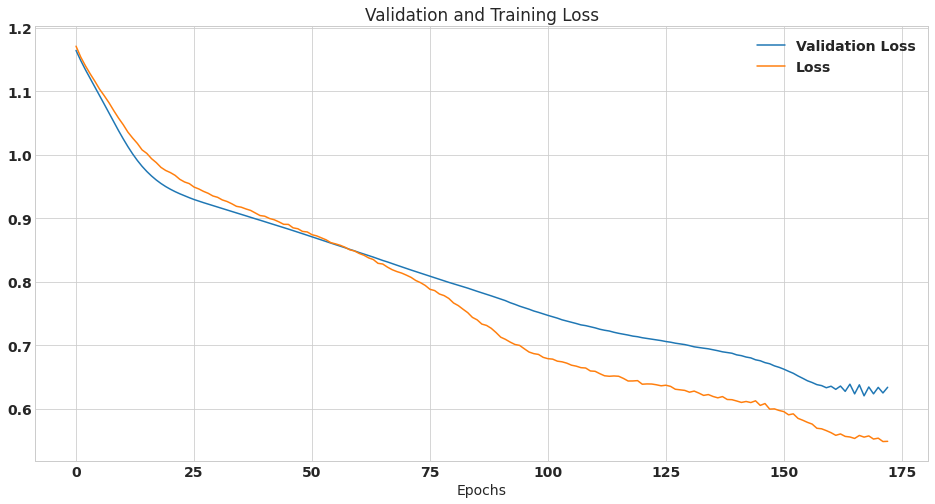

Best epoch for lowest validation loss: 167


In [1942]:
# Plot training loss

plot_series(
    x=range(len(history_gru.history['loss'])), 
    y=(history_gru.history['val_loss'], history_gru.history['loss']), 
    title='Validation and Training Loss', 
    xlabel='Epochs',
    legend=['Validation Loss', 'Loss']
    )

hist = pd.DataFrame(history_gru.history)
hist['epoch'] = history_gru.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('Best epoch for lowest validation loss:', best_epoch)

In [1943]:
model_gru.summary()

Model: "GRU_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_20 (GRU)                (None, 37)                8436      
                                                                 
 dropout_70 (Dropout)        (None, 37)                0         
                                                                 
 dense_235 (Dense)           (None, 365)               13870     
                                                                 
Total params: 22,306
Trainable params: 22,306
Non-trainable params: 0
_________________________________________________________________


In [1944]:
# Make forecast

pred_gru = pd.DataFrame(model_gru.predict(X_test_sequence)).T

1/1 [==============================] - 0s 318ms/step


In [1945]:
# Evaluating results

mse, mae = compute_metrics(y_true, scaler_train.inverse_transform(pred_gru))

print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 5.778, mae: 4.645


In [1946]:
# Training model to forecast 1 year ahead

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=2)


model_gru = GRU_model()

history_bilstm = model_gru.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = G.BATCH_SIZE, 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

forecast_gru = model_gru.predict(X_forecast).astype(float)
forecast_gru_df = pd.DataFrame(scaler_forecast.inverse_transform(forecast_gru).T)
forecast_gru_df.columns = ['Y_PRED']

Epoch 1/167
45/45 [==============================] - 6s 87ms/step - loss: 1.1857
Epoch 2/167
45/45 [==============================] - 7s 156ms/step - loss: 1.1615
Epoch 3/167
45/45 [==============================] - 5s 98ms/step - loss: 1.1415
Epoch 4/167
45/45 [==============================] - 4s 87ms/step - loss: 1.1219
Epoch 5/167
45/45 [==============================] - 6s 128ms/step - loss: 1.1009
Epoch 6/167
45/45 [==============================] - 6s 121ms/step - loss: 1.0802
Epoch 7/167
45/45 [==============================] - 4s 87ms/step - loss: 1.0593
Epoch 8/167
45/45 [==============================] - 5s 106ms/step - loss: 1.0396
Epoch 9/167
45/45 [==============================] - 7s 144ms/step - loss: 1.0222
Epoch 10/167
45/45 [==============================] - 4s 88ms/step - loss: 1.0091
Epoch 11/167
45/45 [==============================] - 4s 92ms/step - loss: 0.9962
Epoch 12/167
45/45 [==============================] - 7s 160ms/step - loss: 0.9872
Epoch 13/167
45/45 

45/45 [==============================] - 5s 112ms/step - loss: 0.5947
Epoch 101/167
45/45 [==============================] - 6s 136ms/step - loss: 0.5931
Epoch 102/167
45/45 [==============================] - 4s 87ms/step - loss: 0.5904
Epoch 103/167
45/45 [==============================] - 4s 96ms/step - loss: 0.5864
Epoch 104/167
45/45 [==============================] - 7s 157ms/step - loss: 0.5879
Epoch 105/167
45/45 [==============================] - 4s 88ms/step - loss: 0.5859
Epoch 106/167
45/45 [==============================] - 4s 92ms/step - loss: 0.5859
Epoch 107/167
1/1 [==============================] - 0s 355ms/step


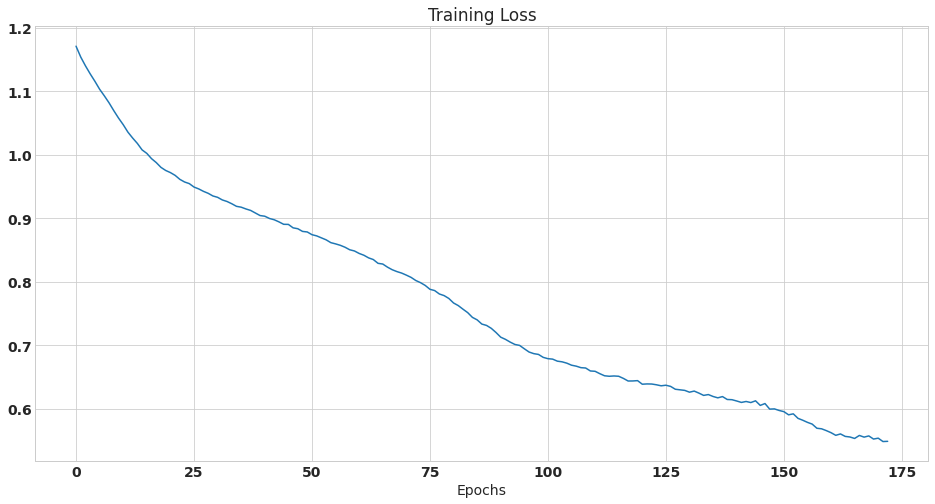

In [1947]:
# Plot training loss

plot_series(
    x=range(len(history_gru.history['loss'])), 
    y=history_gru.history['loss'], 
    title='Training Loss', 
    xlabel='Epochs'
    )

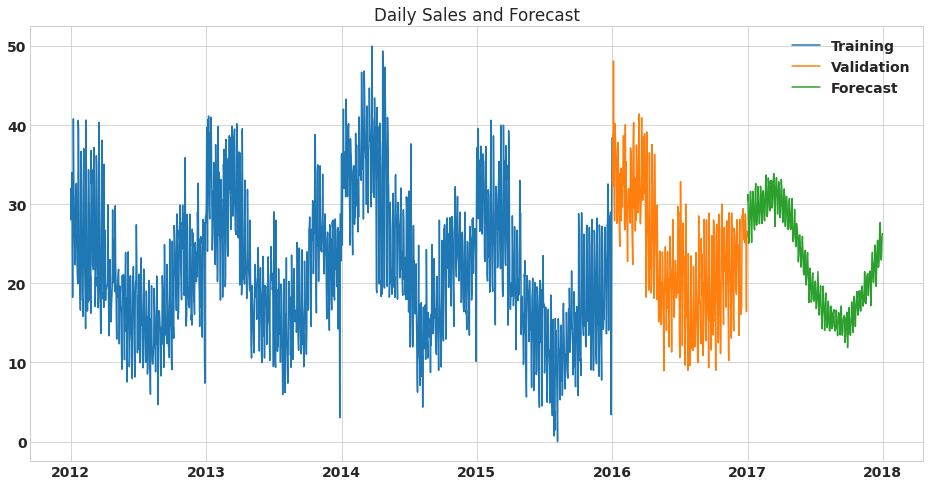

In [1948]:
# Plot whole series + forecast

forecast_gru_df.index = forecast_dates.index
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(G.TS.index[:-G.FORECAST_HORIZON],  G.TS['sales'][:-G.FORECAST_HORIZON])
ax.plot(G.TS.index[-G.FORECAST_HORIZON:], G.TS['sales'][-G.FORECAST_HORIZON:])
ax.plot(forecast_gru_df.index, forecast_gru_df)
plt.title('Daily Sales and Forecast')
plt.grid('True')
plt.legend(['Training', 'Validation', 'Forecast'])
plt.show()

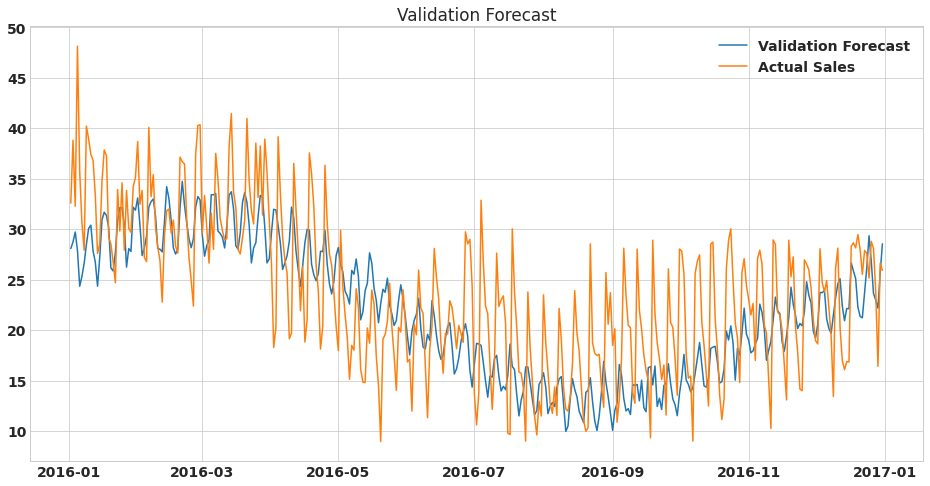

In [1949]:
# Plot validation forecast

plot_series(G.TS.index[-G.FORECAST_HORIZON:], (scaler_train.inverse_transform(pred_gru),G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['Validation Forecast', 'Actual Sales'])

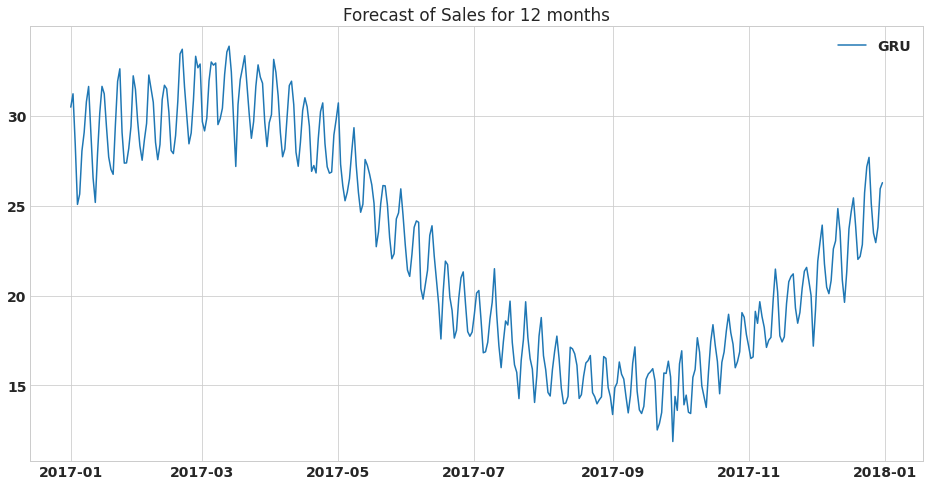

In [1950]:
# Forecast for 1 year ahead

plot_series(forecast_gru_df.index, forecast_gru_df, title='Forecast of Sales for 12 months', legend=['GRU'])

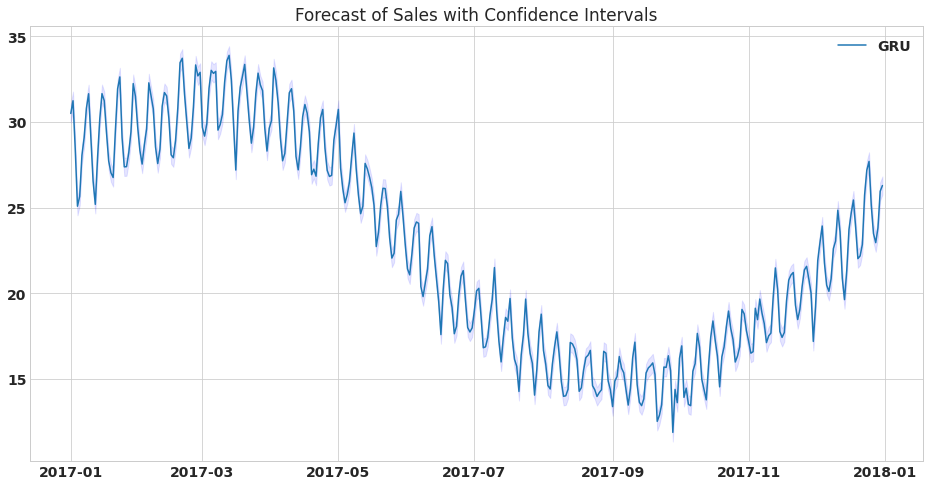

In [2116]:
# Forecast for 1 year ahead with 95 % confidence intervals

ci = 1.960*forecast_gru_df.std(axis=0)/forecast_gru_df.mean(axis=0)
ci_minus = np.array([x - ci for x in forecast_gru_df['Y_PRED']]).ravel()
ci_plus = np.array([x + ci for x in forecast_gru_df['Y_PRED']]).ravel()
plt.plot(forecast_gru_df.index, forecast_gru_df.values)
plt.fill_between(forecast_gru_df.index, ci_plus, ci_minus, color='b', alpha=.1)
plt.legend(['GRU'])
plt.title('Forecast of Sales with Confidence Intervals')
plt.show()

## Time2Vec-BiLSTM

In [1952]:
# Creating Time2Vec layer for the model

class Time2Vec(Layer):
    """S. M. Kazemi, R. Goel, S. Eghbali, J. Ramanan, J. Sahota, S. Thakur,
    S. Wu, C. Smyth, P. Poupart,  and M. Brubaker, (2019),
    "Time2Vec: Learning a Vector Representation of Time.", arXiv:1907.0532lvl 
    """
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(Time2Vec, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [1956]:
# Creating the model

def T2V_BILSTM_model():
    inp = Input(shape=(X_train_sequence.shape[1],
                   X_train_sequence.shape[2]))
    x = Time2Vec(120)(inp)
    x = Bidirectional(LSTM(48, activation='tanh', return_sequences = True))(x)
    x = Dense(y_train_sequence.shape[1])(x)

    model = Model(inp, x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True) 
    model.compile(optimizer=opt, loss='mse')
    model.summary()
    
    return model
    
model_t2v = T2V_BILSTM_model()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 365, 37)]         0         
                                                                 
 time2_vec_40 (Time2Vec)     (None, 365, 157)          48970     
                                                                 
 bidirectional_183 (Bidirect  (None, 365, 96)          79104     
 ional)                                                          
                                                                 
 dense_238 (Dense)           (None, 365, 365)          35405     
                                                                 
Total params: 163,479
Trainable params: 163,479
Non-trainable params: 0
_________________________________________________________________


In [1957]:
# Training the model

monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=8)
history_t2v = model_t2v.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=150, 
                    batch_size = G.BATCH_SIZE, 
                    validation_data = (X_train_full[-G.FORECAST_HORIZON:, :, :],
                                       y_train_full[-G.FORECAST_HORIZON:, :, :]), 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

Epoch 1/150
30/30 [==============================] - 24s 697ms/step - loss: 1.0218 - val_loss: 0.8058
Epoch 2/150
30/30 [==============================] - 22s 735ms/step - loss: 0.7284 - val_loss: 0.6668
Epoch 3/150
30/30 [==============================] - 20s 656ms/step - loss: 0.6321 - val_loss: 0.6234
Epoch 4/150
30/30 [==============================] - 20s 671ms/step - loss: 0.5866 - val_loss: 0.5241
Epoch 5/150
30/30 [==============================] - 20s 691ms/step - loss: 0.5239 - val_loss: 0.5111
Epoch 6/150
30/30 [==============================] - 21s 680ms/step - loss: 0.4705 - val_loss: 0.5207
Epoch 7/150
30/30 [==============================] - 18s 612ms/step - loss: 0.4388 - val_loss: 0.5076
Epoch 8/150
30/30 [==============================] - 18s 611ms/step - loss: 0.4154 - val_loss: 0.4961
Epoch 9/150
30/30 [==============================] - 18s 619ms/step - loss: 0.3873 - val_loss: 0.5013
Epoch 10/150
30/30 [==============================] - 19s 623ms/step - loss: 0.369

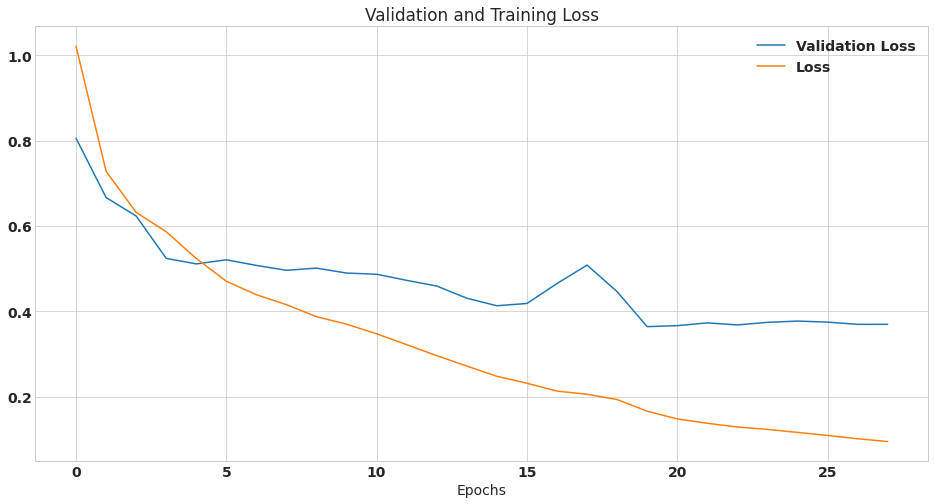

Best epoch for lowest validation loss: 19


In [1958]:
# Plot training loss

plot_series(
    x=range(len(history_t2v.history['loss'])), 
    y=(history_t2v.history['val_loss'], history_t2v.history['loss']), 
    title='Validation and Training Loss', 
    xlabel='Epochs',
    legend=['Validation Loss', 'Loss']
    )

hist = pd.DataFrame(history_t2v.history)
hist['epoch'] = history_t2v.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('Best epoch for lowest validation loss:', best_epoch)

In [1959]:
# Make forecast

pred_t2v = pd.DataFrame(model_t2v.predict(X_forecast)[0,:].T) # transform 3D to 2D
pred_t2v = pd.DataFrame(np.mean(pred_t2v.T, axis = 1))

1/1 [==============================] - 1s 904ms/step


In [1960]:
# Evaluating results

mse, mae = compute_metrics(y_true, scaler_train.inverse_transform(pred_t2v))

print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 6.457, mae: 5.237


In [1961]:
# Training model to forecast 1 year ahead

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=2)


model_t2v = T2V_BILSTM_model()

history_t2v = model_t2v.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = G.BATCH_SIZE, 
                    shuffle = False,
                    verbose=1,
                    callbacks=[early_stop])

forecast_t2v = pd.DataFrame(np.mean(model_t2v.predict(X_forecast), axis= 0)).astype(float) # shape (1, 365, 365)
forecast_t2v = pd.DataFrame(np.mean(forecast_t2v, axis = 1))
forecast_t2v_df = pd.DataFrame(scaler_forecast.inverse_transform(forecast_t2v))
forecast_t2v_df.columns = ['Y_PRED']

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 365, 37)]         0         
                                                                 
 time2_vec_41 (Time2Vec)     (None, 365, 157)          48970     
                                                                 
 bidirectional_184 (Bidirect  (None, 365, 96)          79104     
 ional)                                                          
                                                                 
 dense_239 (Dense)           (None, 365, 365)          35405     
                                                                 
Total params: 163,479
Trainable params: 163,479
Non-trainable params: 0
_________________________________________________________________
Epoch 1/19
45/45 [==============================] - 27s 505ms/step - loss: 0.9701
Epoch 2/19
45/45 [==================

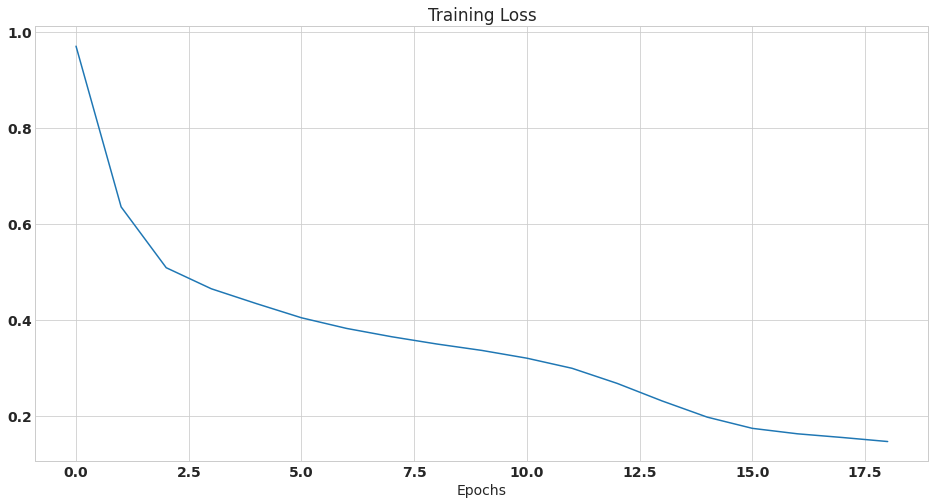

In [1962]:
# Plot training loss

plot_series(
    x=range(len(history_t2v.history['loss'])), 
    y=history_t2v.history['loss'], 
    title='Training Loss', 
    xlabel='Epochs'
    )

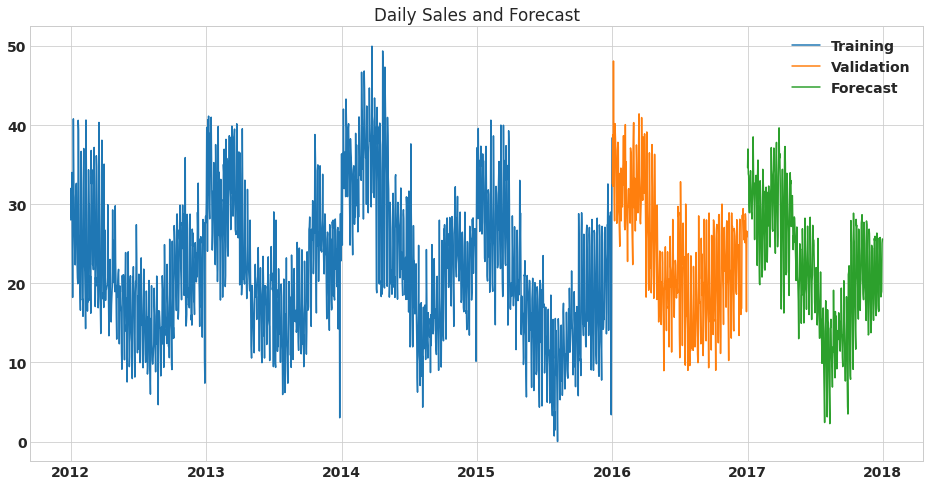

In [1963]:
# Plot whole series + forecast

forecast_t2v_df.index = forecast_dates.index
fig, ax = plt.subplots(figsize = (16,8))
ax.plot(G.TS.index[:-G.FORECAST_HORIZON],  G.TS['sales'][:-G.FORECAST_HORIZON])
ax.plot(G.TS.index[-G.FORECAST_HORIZON:], G.TS['sales'][-G.FORECAST_HORIZON:])
ax.plot(forecast_t2v_df.index, forecast_t2v_df)
plt.title('Daily Sales and Forecast')
plt.grid('True')
plt.legend(['Training', 'Validation', 'Forecast'])
plt.show()

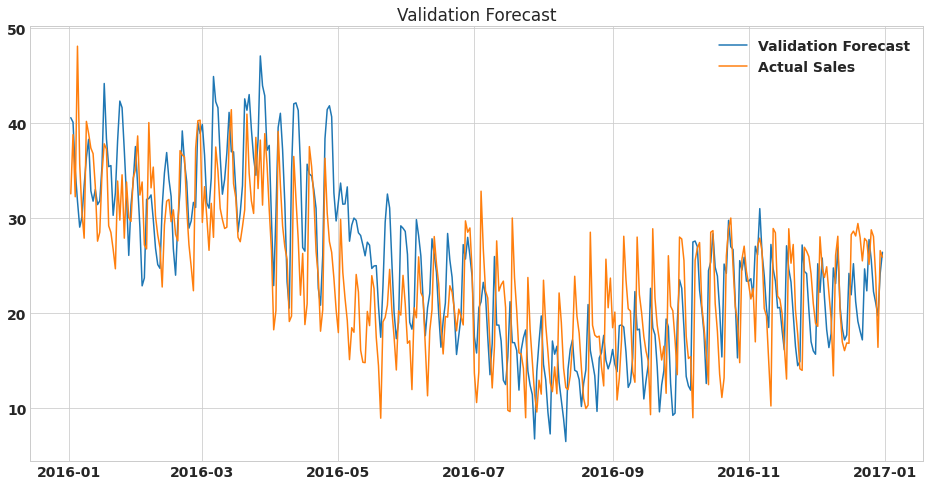

In [1964]:
# Plot validation forecast

plot_series(G.TS.index[-G.FORECAST_HORIZON:], (scaler_train.inverse_transform(pred_t2v),G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['Validation Forecast', 'Actual Sales'])

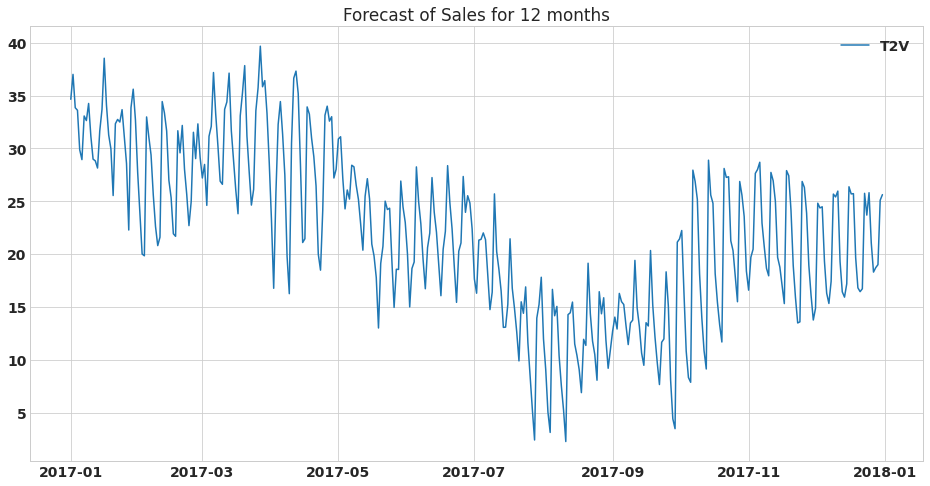

In [1965]:
# Forecast for 1 year ahead

plot_series(forecast_t2v_df.index, forecast_t2v_df, title='Forecast of Sales for 12 months', legend=['T2V'])

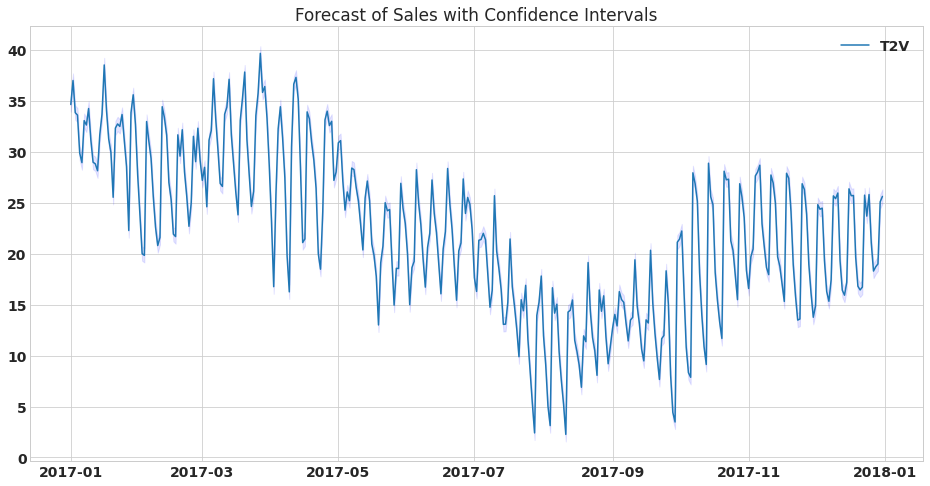

In [2117]:
# Forecast for 1 year ahead with confidence intervals

ci = 1.960*forecast_t2v_df.std(axis=0)/forecast_t2v_df.mean(axis=0)
ci_minus = np.array([x - ci for x in forecast_t2v_df['Y_PRED']]).ravel()
ci_plus = np.array([x + ci for x in forecast_t2v_df.values]).ravel()

plt.plot(forecast_t2v_df.index, forecast_t2v_df.values)
plt.fill_between(forecast_t2v_df.index, ci_plus, ci_minus, color='b', alpha=.1)
plt.legend(['T2V'])
plt.title('Forecast of Sales with Confidence Intervals')
plt.show()

## Ensemble Models

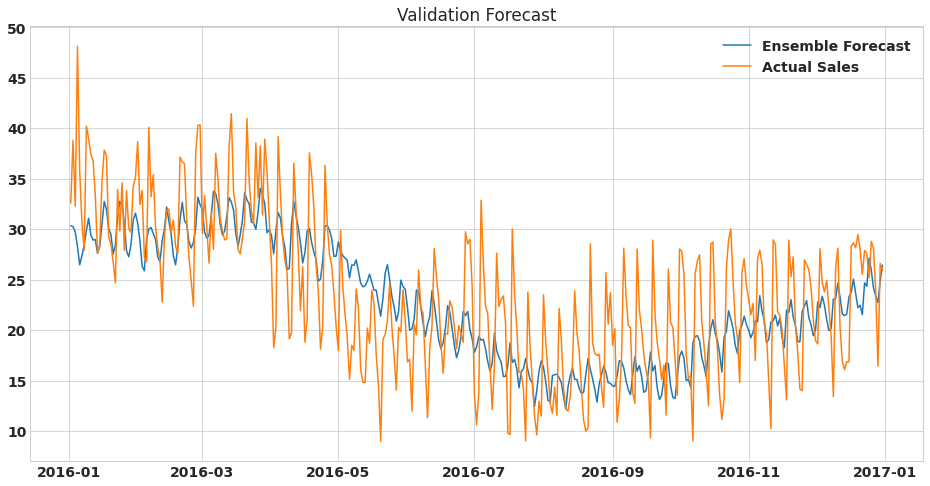

In [1967]:
# Plotting ensemble forecast for validation set

tv2preds = y_scaler_sequence.inverse_transform(pred_t2v)
grupreds = y_scaler_sequence.inverse_transform(pred_gru)
lstmpreds = y_scaler_sequence.inverse_transform(pred_lstm)
bilstmpreds = y_scaler_sequence.inverse_transform(pred_bilstm)        
ensemble_validation = (tv2preds + grupreds + lstmpreds + bilstmpreds) / 4

plot_series(G.TS.index[-G.FORECAST_HORIZON:], (ensemble_validation , G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['Ensemble Forecast', 'Actual Sales'])

In [1968]:
# Evaluating results

mse, mae = compute_metrics(y_true, ensemble_validation)
print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 5.382, mae: 4.377


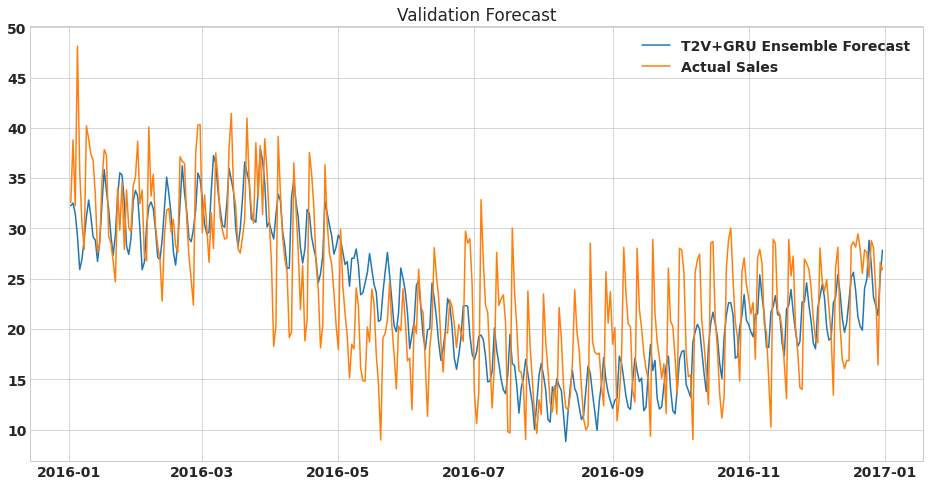

In [2003]:
# Plotting T2V+GRU ensemble forecast for validation set

t2vgru_validation = (tv2preds * 1/3 + grupreds * 2/3)
plot_series(G.TS.index[-G.FORECAST_HORIZON:], (t2vgru_validation , G.TS['sales'][-G.FORECAST_HORIZON:]), title='Validation Forecast', legend=['T2V+GRU Ensemble Forecast', 'Actual Sales'])

In [2004]:
# Evaluating results

mse, mae = compute_metrics(y_true, t2vgru_validation)
print(f"rmse: {np.sqrt(mse.mean()):.3f}, mae: {mae.mean():.3f}")

rmse: 5.410, mae: 4.369


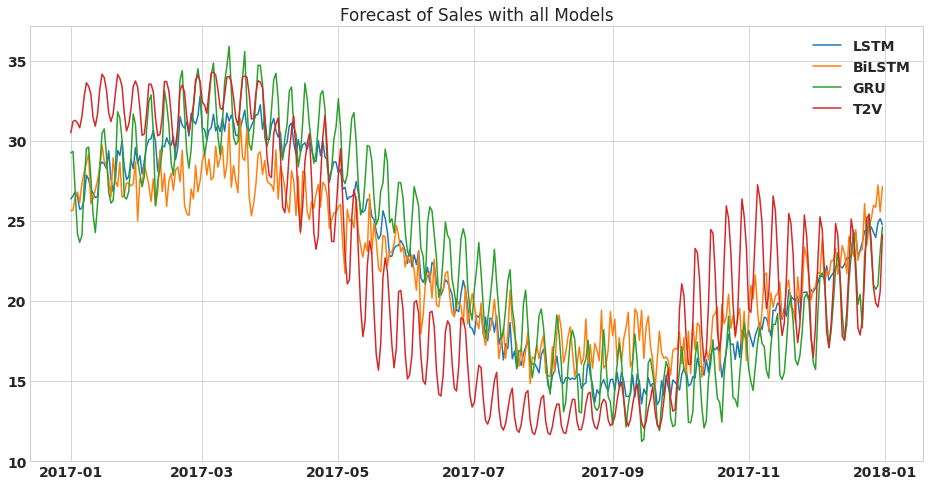

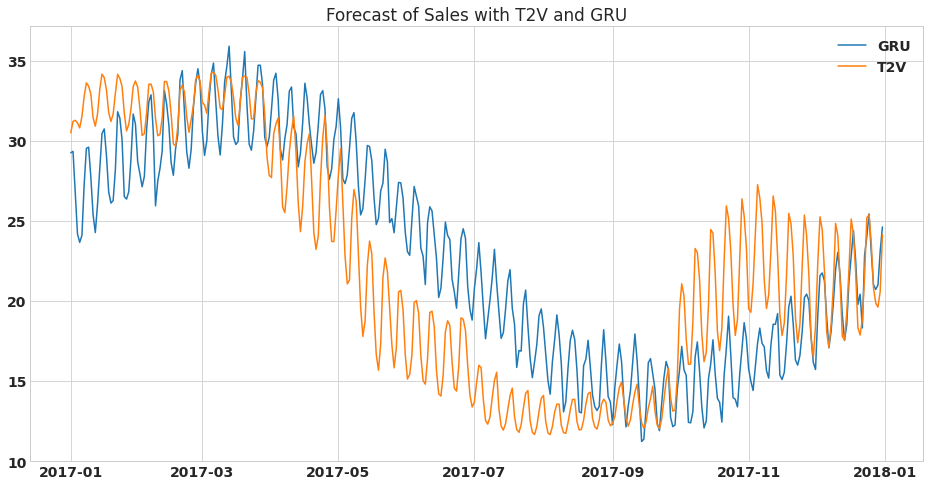

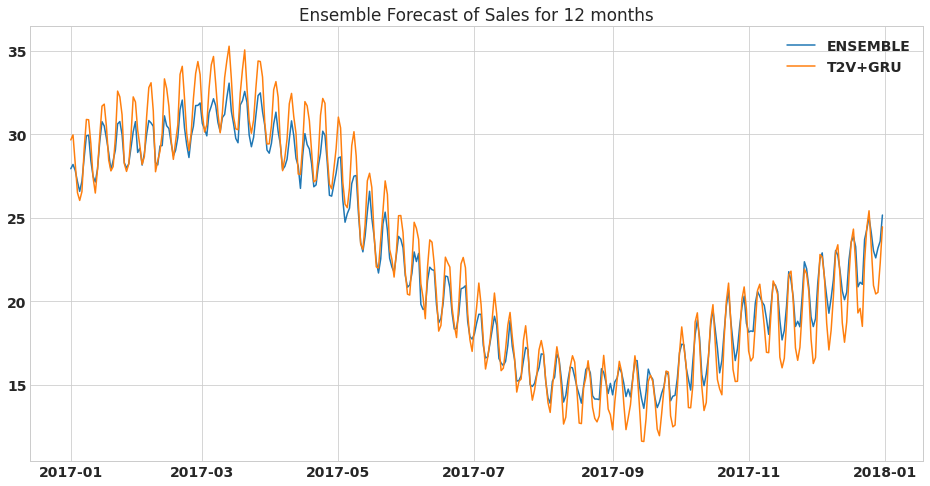

In [2006]:
# Forecast for 1 year ahead with all models and ensemble models


ensemble_forecast = (pred_forecast_lstm + pred_forecast_bilstm + pred_forecast_gru + pred_forecast_t2v) / 4
t2vgru_forecast = (pred_forecast_gru * 2/3 + pred_forecast_t2v * 1/3) 
ensemble_forecast_std = ensemble_forecast.std(axis=0)
plot_series(pred_forecast.index, (pred_forecast_lstm, pred_forecast_bilstm, pred_forecast_gru, pred_forecast_t2v), legend=['LSTM','BiLSTM','GRU','T2V'], title='Forecast of Sales with all Models')
plot_series(pred_forecast.index, (pred_forecast_gru, pred_forecast_t2v), legend=['GRU', 'T2V'], title='Forecast of Sales with T2V and GRU')
plot_series(pred_forecast.index, (ensemble_forecast, t2vgru_forecast), legend=['ENSEMBLE', 'T2V+GRU'], title='Ensemble Forecast of Sales for 12 months')


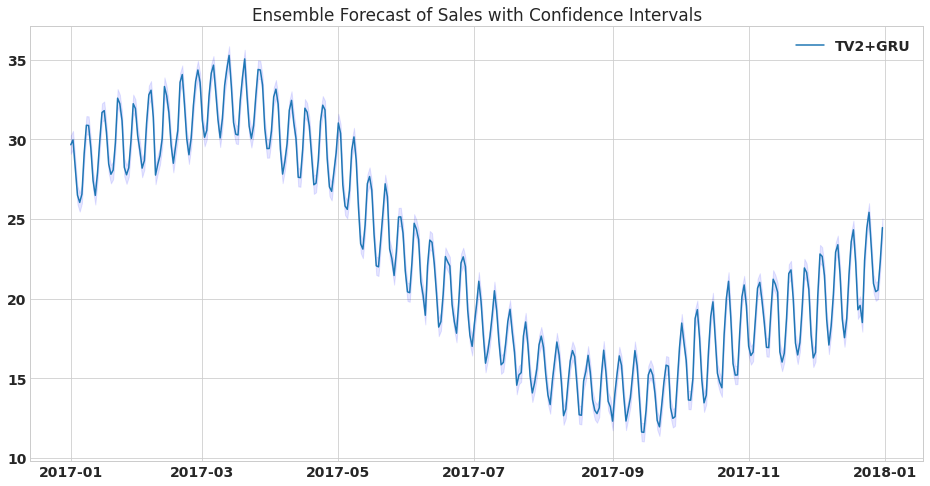

In [2118]:
# Plotting ensemble forecast with 95 % confidence intervals

ci = 1.960*t2vgru_forecast.std(axis=0)/t2vgru_forecast.mean(axis=0)
ci_minus = np.array([x - ci for x in t2vgru_forecast['Y_PRED']]).ravel()
ci_plus = np.array([x + ci for x in t2vgru_forecast['Y_PRED']]).ravel()

plt.plot(pred_forecast.index, t2vgru_forecast.values,)
plt.fill_between(pred_forecast.index, ci_plus, ci_minus, color='b', alpha=.1)
plt.legend(['TV2+GRU'])
plt.title('Ensemble Forecast of Sales with Confidence Intervals')
plt.show()

# Conclusions

We could see from the results that all the models performed rather well with the task, and at each time a new model was introduced to the task, it slightly outperformed the previous one. By using an ensemble model that consisted of all the four different models or the two best ones, the GRU and the T2V, the network was able to achieve the best results with a MAE of 4.377 or 4.369. This means the algorithm was able to predict the sales with an accuracy that missed on average by 4 product sales per day for a timespan of 1 year of sales, which could be considered a rather good result especially if you consider having that amount of extra products each day ready to be sold in the stock, so that you anticipate the small uncertainty in the forecast.

For the future, the algorithm predicted the highest sales for the upcoming month of March with around 30 to 35 sold products per day, and in turn the lowest for September with around 12 to 17 sold products per day. This is also consistent with the past behaviour for the demand of sales that could be seen from trend and seasonal components of the decomposition from the monthly average sales.